In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, os
import warnings
import glob
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.signal import peak_prominences
from scipy.stats.mstats import chisquare, kstest
from scipy.signal import find_peaks


import PySimpleGUI as sg
from bokeh.plotting import figure, show, output_file
from bokeh.models import Span, ColumnDataSource, Slider, CustomJS, Button, Range1d
from bokeh.io import output_notebook, curdoc
from bokeh.layouts import column, row
from bokeh.events import ButtonClick

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from astropy.io import fits
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
from astropy.table import Table, vstack, hstack, join
from astropy.modeling import models
from astropy.modeling.fitting import LevMarLSQFitter
from specutils.fitting import find_lines_threshold, find_lines_derivative, fit_lines
from specutils.manipulation import noise_region_uncertainty, trapezoid_smooth, box_smooth, gaussian_smooth, median_smooth
from specutils import Spectrum1D, SpectralRegion
from astropy.nddata import NDUncertainty


from astroquery.simbad import Simbad
from astroquery.nist import Nist
from astroquery.xmatch import XMatch
from astroquery.vizier import Vizier
from astroquery.mast import Observations

# %matplotlib inline
# output_notebook()

In [9]:
## Where should results be saved to?

analysispath = '/Users/isabelkain/Desktop/GALEX/analysis'
datapath = '/Volumes/Seagate/seagate_backup/GALEX/data'
# datapath = '/Users/isabelkain/Desktop/GALEX/data'


In [10]:
def redshift_correction(wavelengths_observed, z):
    '''
    Finds amount by which stellar emission is redshifted, and subtract this from stellar spectrum.
    Input:
    wavelengths_observed: observed wavelengths of spectrum (Angstroms)
    z: redshift of star
    
    Returns:
    wavelengths_emitted: emitted wavelengths of spectrum (Angstroms)
    '''
    
    wavelengths_emitted = wavelengths_observed / (1 + z)
    return wavelengths_emitted


def blackbody(wavelengths, Teff):
    '''
    Returns blackbody continuum for an object at Teff (K)
    Inputs:
    wavelengths [arr]: (Angstroms)
    Teff [scalar]: effective temperature (K)
    
    Returns:
    B [arr]: blackbody continuum for Teff (unitless)
    '''
    
    wav = wavelengths * angstrom2meter * u.m
    Teff = Teff * u.K
    
    B = (2. * const.h * const.c**2) / (wav**5.) / ( np.exp( (const.h * const.c) / (wav * const.k_B * Teff) ) - 1. )
    
    return (B / B.max()).value


def fitBB_fixedTeff(wavelengths, Teff, a, b):
    '''
    Scale blackbody continuum emission.
    Input:
    wavelengths [arr]: spectrum wavelengths (Angstroms)
    Teff [scalar]: effective temperature of star (K)
    a, b: scaling factors to be optimized by curve_fit
    '''
    return a * blackbody(wavelengths, Teff) + b


def fitBB_fitTeff(wavelengths, Teff, a, b):
    '''
    Fit blackbody emission to spectrum continuum. 
    Input:
    wavelengths [arr]: spectrum wavelengths (Angstroms)
    Teff [scalar]: effective temperature of star (K) (will be optimized by curve_fit)
    a, b: scaling factors to be optimized by curve_fit
    
    Returns:
    -- [arr]: blackbody continuum curve
    '''
    
    wav = wavelengths * angstrom2meter * u.m
    Teff = Teff * u.K
    
    B = (2. * const.h * const.c**2) / (wav**5.) / ( np.exp( (const.h * const.c) / (wav * const.k_B * Teff) ) - 1. )

    return a * (B / B.max()).value + b


def MAD(array):
    '''
    Return the median absolute deviation (MAD) of array
    Input:
    array [arr]: 1xn array of values
    
    Returns:
    -- [scalar]: MAD
    '''
    med = np.median(array)
    return np.median([abs(num - med) for num in array])


def gaussian(x, a, b, c):
    '''
    a: amplitude of peak
    b: position of peak
    c: standard deviation
    '''
    return a * np.exp( -(x - b)**2 / (2*c**2) )


##########################
## Define helper functions
##########################

angstrom2meter = 10**-10
joules2ergs = 10**7

# Read in data

In [138]:
table = Table.read(f'{analysispath}/dataset.ecsv')
table['Peaks identified'] = [False]*len(table)
table.write(f'{analysispath}/dataset.ecsv', overwrite=True)

In [139]:
table = Table.read(f'{analysispath}/dataset.ecsv')
table#['Peaks identified']

main_id,main_type,sp_type,obs_id,s_ra,s_dec,RAJ2000,DEJ2000,ra,dec,t_min,t_max,t_exptime,obs_title,jpegURL,dataURL,RAfdeg,DEfdeg,FUVexp,NUVexp,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fflux,e_Fflux,Nflux,e_Nflux,coo_qual,coo_bibcode,other_types,radvel,radvel_err,redshift,redshift_err,plx,plx_err,pmra,pmdec,B,V,R,J,H,K,u,g,r,i,z,FLUX_B,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_QUAL_V,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_QUAL_R,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_QUAL_I,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_QUAL_J,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_QUAL_K,TYPED_ID,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,SP_TYPE,SP_QUAL,OTYPE,V__vartyp,V__LoVmax,V__Vmax,V__R_Vmax,V__magtyp,V__UpVmin,V__Vmin,V__R_Vmin,V__UpPeriod,V__period,V__R_period,V__epoch,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,Distance_distance,Distance_unit,Distance_merr,Distance_perr,Distance_method,Peaks verified,Peaks identified,Rerun verification,Rerun identification
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,,,mag,,,,mag,,,,mag,,,,mag,,,,,unit-degK,cm / s2,,,,km / s,,,,,,,,,mag,,,,mag,,,d,,d,mas,,mas,,,,,,,,,,
str23,str19,str18,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str114,str74,str64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,str1,str19,str33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,object,int32,float32,float32,str1,str1,float32,float32,int32,str1,object,str1,object,str4,str1,float32,str1,str1,str1,float32,str1,str1,float64,str1,float64,float64,int16,float32,str1,float64,str2,float64,float64,str5,bool,bool,bool,bool
* gam Mic,Star,G8III,swp54894,315.3224724693,-32.2577449364,315.322853,-32.257566,315.3227519696,-32.2577659353,49875.41707,49875.45873,3599.844,IUE Survey of X-Ray Selected Late-Type Stars,http://archive.stsci.edu/browse/previews/iue/mx/swp/54000/gif/swp54894.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp54894mxlo_vo.fits,315.444385,-32.448868,157.0,157.0,17.2783,0.0402,12.2301,0.0027,0,2,0,0,445.323,16.4837,46554.0,117.279,A,2007A&A...474..653V,*|**|IR|UV|X,17.5,0.36,5.84e-05,1.2e-06,14.24,0.26,-1.73,0.41,5.529,4.654,--,3.15,2.713,2.596,--,--,--,--,--,5.529,0.009,Vega,D,--,--,,--,--,--,,--,3.15,0.010,Vega,B,2.596,0.010,Vega,B,* gam Mic,5310,3.0000,-0.010,--,--,--,--,0,--,G8III,C,Star,--,--,--,--,--,--,--,--,--,--,--,--,14.240,2,0.26,A,68.2929,pc,-2.3161,2.3161,paral,True,False,False,False
HD 2454,PM*,F5VSr,swp55292,7.083429661399975,10.1900690724,7.083387,10.189901,7.0835103411,10.1898049067,49914.07061,49914.09145,1799.522,The White Dwarf Luminosity Function in F-K Binaries,http://archive.stsci.edu/browse/previews/iue/mx/swp/55000/gif/swp55292.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp55292mxlo_vo.fits,7.182728,10.038623,215.0,215.0,15.2804,0.0112,11.7018,0.0018,0,2,0,0,2804.53003,29.043,75731.89844,123.038,A,2020yCat.1350....0G,*|IR|PM*|Ro*|UV,-8.62,0.2,-2.88e-05,7e-07,26.2526,0.057,42.022,-180.181,6.47,--,5.8,5.201,5.057,4.942,--,--,--,--,--,6.47,--,,--,5.8,--,Vega,E,--,--,,--,5.201,0.037,Vega,C,4.942,0.020,Vega,C,HD 2454,6501,4.1100,-0.350,--,--,--,--,0,--,F5VSr,C,HighPM*,ROT,--,--,--,--,--,--,--,--,3.000000,--,--,26.253,3,0.057,A,38.0910,pc,-0.0827,0.0827,paral,True,False,False,False
* ksi01 Lib,PM*,K0III,swp55297,223.59536528340004,-11.8983649295,223.595816,-11.898603,223.5953088134,-11.8983503771,49914.87583,49914.92235,4019.145,--,http://archive.stsci.edu/browse/previews/iue/mx/swp/55000/gif/swp55297.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp55297mxlo_vo.fits,223.657823,-11.517354,89.0,90.0,20.5984,0.3548,13.6332,0.0069,256,0,0,0,20.9243,6.83601,12785.2002,81.2597,A,2020yCat.1350....0G,*|IR|PM

In [129]:
table = Table.read(f'{analysispath}/dataset.ecsv')

# swpid = table['obs_id'][table['main_id']=='* gam Mic'][0]       ## SWP ID, e.g. swp54894
# starname = table['main_id'][table['main_id']=='* gam Mic'][0]   ## Star name, e.g. * gam Mic
# objname = starname.replace(' ','')                              ## No-spaces star name, e.g. *gamMic

swpid = 'swp51734'
row = table[table['obs_id']==swpid]
starname = table['main_id'][table['obs_id']==swpid][0]
objname = starname.replace(' ','')
tblrow = table[table['main_id']==starname][0]


# starname = '* gam Mic'
# tblrow = table[table['main_id']==starname][0]
# swpid = table['obs_id'][table['main_id']==starname][0]
# objname = starname.replace(' ','')


print(starname, swpid, objname)
tblrow


HD  35949 swp51734 HD35949


main_id,main_type,sp_type,obs_id,s_ra,s_dec,RAJ2000,DEJ2000,ra,dec,t_min,t_max,t_exptime,obs_title,jpegURL,dataURL,RAfdeg,DEfdeg,FUVexp,NUVexp,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fflux,e_Fflux,Nflux,e_Nflux,coo_qual,coo_bibcode,other_types,radvel,radvel_err,redshift,redshift_err,plx,plx_err,pmra,pmdec,B,V,R,J,H,K,u,g,r,i,z,FLUX_B,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_QUAL_V,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_QUAL_R,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_QUAL_I,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_QUAL_J,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_QUAL_K,TYPED_ID,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,SP_TYPE,SP_QUAL,OTYPE,V__vartyp,V__LoVmax,V__Vmax,V__R_Vmax,V__magtyp,V__UpVmin,V__Vmin,V__R_Vmin,V__UpPeriod,V__period,V__R_period,V__epoch,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,Distance_distance,Distance_unit,Distance_merr,Distance_perr,Distance_method,Peaks verified,Peaks identified,Rerun verification,Rerun identification
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,,,mag,,,,mag,,,,mag,,,,mag,,,,,unit-degK,cm / s2,,,,km / s,,,,,,,,,mag,,,,mag,,,d,,d,mas,,mas,,,,,,,,,,
str23,str19,str18,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str114,str74,str64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,str1,str19,str33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,object,int32,float32,float32,str1,str1,float32,float32,int32,str1,object,str1,object,str4,str1,float32,str1,str1,str1,float32,str1,str1,float64,str1,float64,float64,int16,float32,str1,float64,str2,float64,float64,str5,bool,bool,bool,bool
HD 35949,Star,F3Ib/II,swp51734,81.29630715209998,-54.3186527355,81.296884,-54.317453,81.2959070315,-54.3178702039,49571.98688,49572.00214,1319.601,UV Spectroscopic Survey of Bright Stars,http://archive.stsci.edu/browse/previews/iue/mx/swp/51000/gif/swp51734.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp51734mxlo_vo.fits,80.567801,-54.098477,77.0,77.0,16.1077,0.0415,13.3428,0.0064,0,17,0,0,1309.0,50.0454,16706.09961,97.9095,A,2020yCat.1350....0G,*|IR|UV,23.6,0.3,7.87e-05,1e-06,7.137,0.0178,0.626,41.163,7.59,7.15,--,6.329,6.158,6.075,--,--,--,--,--,7.59,0.010,Vega,D,--,--,,--,--,--,,--,6.329,0.023,Vega,C,6.075,0.018,Vega,C,HD 35949,6623,--,--,--,--,--,--,0,--,F3Ib/II,C,Star,--,--,--,--,--,--,--,--,--,--,--,--,7.137,4,0.0178,A,140.1150,pc,-0.3495,0.3495,paral,True,False,False,False


In [130]:
table['Rerun verification'] = [True]*len(table)
table.write(f'{analysispath}/dataset.ecsv', overwrite=True)

In [88]:
## Open FITS file

hdul = fits.open(f'/Users/isabelkain/Desktop/GALEX/data/swp51734.fits')


# Collect info, apply redshift and BB corrections

In [89]:
## Collect exposure information from header

# target = hdul[1].header['OBJECT']       # target name
spclass = hdul[1].header['SRCCLASS']    # Object Class 
camera = hdul[0].header['CAMERA']       # or hdul[1].header['INSTRUME']
dispersion = hdul[0].header['DISPERSN'] # LOW or HIGH
fluxcal = hdul[1].header['FLUX_CAL']    # should be ABSOLUTE
tstart = float(str(hdul[0].header['?JD-OBS']).split('=')[1].split('/')[0].strip())      # [d] MJD exposure start time 
exptime = hdul[1].header['EXPOSURE']    # [s] eff. exposure duration
snr = hdul[1].header['DER_SNR']         # Derived signal-to-noise ratio  


## Record redshift & temperature

z = table[table['main_id']==starname]['redshift'].value[0]
Teff = table[table['main_id']==starname]['Fe_H_Teff'].value[0]

if type(z) == np.ma.core.MaskedConstant: z = 0. # if z masked, assume 0 FIXME

fit_teff = True
if Teff == 0: 
#     fit_teff = True
    Teff = 5000.01 # guess value of 5000 K if no Teff available
# else:
#     fit_teff = False


## Read in wavelength, flux, and fluxerr data

wavelengths = redshift_correction(hdul[1].data['WAVE'][0], z) ## CHECK is this right? seems large
rawflux = hdul[1].data['FLUX'][0] # raw because blackbody continuum will soon be subtracted
fluxerr = hdul[1].data['SIGMA'][0]

print(objname)
print(spclass)
print(camera)
print(dispersion)
print(fluxcal)
print(tstart)
print(exptime)
print(snr)

hdul.close()

HD35949
F0-F2
SWP
LOW
ABSOLUTE
2449571.98688
1319.601
2.39


In [90]:
fit_teff = True
if Teff == 0: 
#     fit_teff = True
    Teff = 5000.01 # guess value of 5000 K if no Teff available
# else:
#     fit_teff = False


Text(0.5, 1.0, 'LOW-DISP SWP, F0-F2, SNR 2.39')

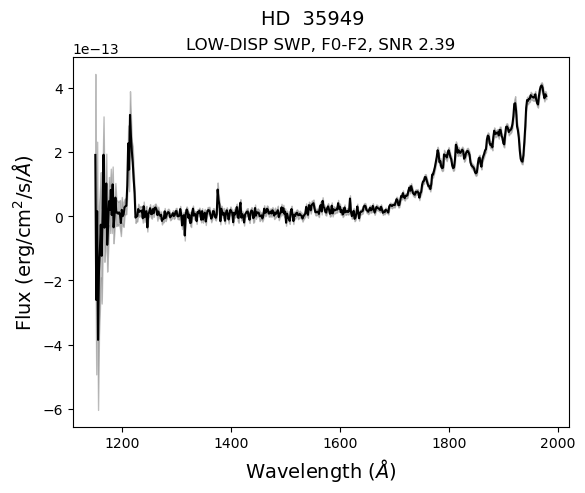

In [91]:
## Visualize spectrum

plt.tight_layout(rect=[0, 0.03, 1, 0.90])

plt.plot( wavelengths, rawflux, c='k')
plt.fill_between(wavelengths, rawflux + fluxerr, rawflux - fluxerr, alpha=0.5, color='gray')

plt.xlabel(r'Wavelength ($\AA$)', fontsize=14)
plt.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

plt.suptitle(f'{starname}', fontsize=14)
plt.title(f'{dispersion}-DISP {camera}, {spclass}, SNR {snr}')

# plt.savefig(f'{analysispath}/{swpid}_{objname}/{swpid}_raw.png', bbox_inches='tight')
# 
# plt.ylim(-.2*10**-13, .5*10**-13)
# plt.yscale('log')

## Test generic continuum subtraction

In [92]:
import warnings
from specutils.fitting import fit_generic_continuum

In [102]:
plt.close('all')

Text(0.5, 0.98, 'swp51734 / HD  35949')

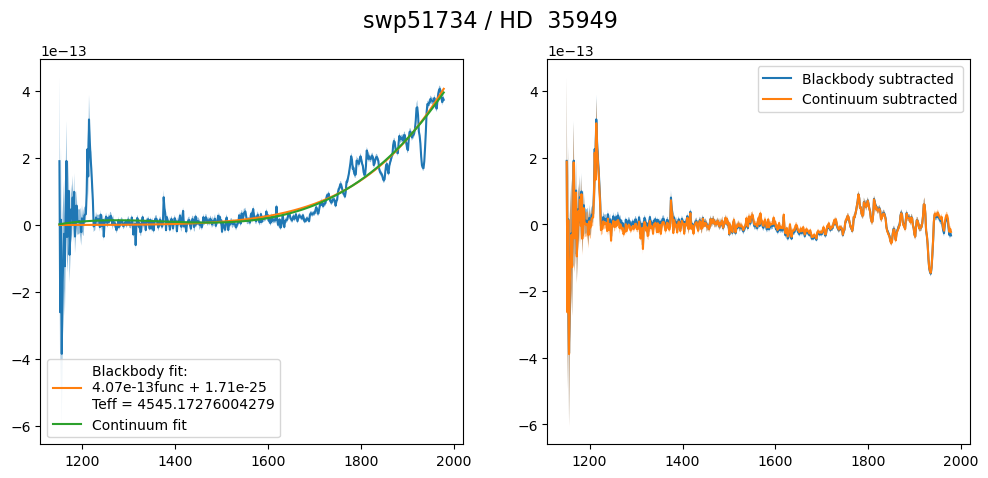

In [101]:
spec = Spectrum1D(flux=rawflux*(u.erg/u.cm**2/u.s/u.AA), spectral_axis=wavelengths*u.AA)

with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    g1_fit = fit_generic_continuum(spec)

y_continuum_fitted = g1_fit(wavelengths*u.AA)

fig, ax = plt.subplots(1,2, figsize=(12,5))  

## Spectrum with blackbody, continuum plotted
ax[0].plot(wavelengths, rawflux) 
ax[0].fill_between(wavelengths, rawflux-fluxerr, rawflux+fluxerr, alpha=0.5) 
ax[0].plot(wavelengths, fitBB_fitTeff(wavelengths, popt[0], popt[1], popt[2]), 
           label=f'Blackbody fit:\n{popt[1]:0.2e}func + {popt[2]:0.2e}\nTeff = {popt[0]}')
ax[0].plot(wavelengths, y_continuum_fitted.value, label='Continuum fit') 

## Spectrum with blackbody, continuum subtracted
ax[1].plot(wavelengths, flux, label='Blackbody subtracted') 
ax[1].fill_between(wavelengths, flux-fluxerr, flux+fluxerr, alpha=0.5) 

ax[1].plot(wavelengths, rawflux - y_continuum_fitted.value, label='Continuum subtracted') 
ax[1].fill_between(wavelengths, (rawflux - y_continuum_fitted.value)-fluxerr, 
                   (rawflux - y_continuum_fitted.value)+fluxerr, alpha=0.5) 

ax[0].legend()
ax[1].legend()

fig.suptitle(f'{swpid} / {starname}', fontsize=16)

# ax.set_xlim(654 * u.nm, 660 * u.nm)  

## Subtract blackbody continuum

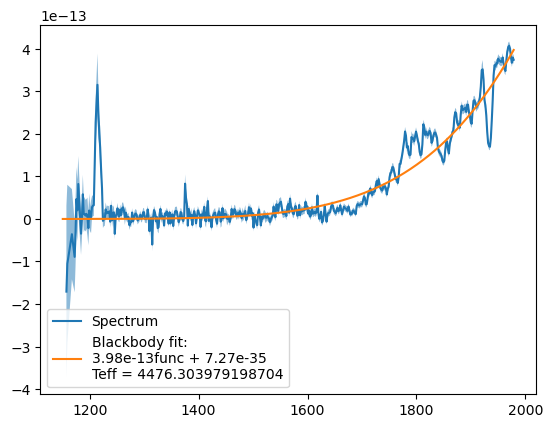

In [24]:
## Scale BB curve 

## Mask most features to let curve_fit see the underlying emission

diff = rawflux[1:] - rawflux[:-1]
diff = np.append(diff, 0.)
std = np.std(diff)
mask = np.logical_and((diff <= 2*std), (diff >= -2*std))

x = wavelengths[mask]
y = rawflux[mask]
yerr = fluxerr[mask]



## Fit blackbody curve to masked stellar spectrum

if fit_teff:
    popt, pcov = curve_fit(fitBB_fitTeff, x, y, p0=[Teff, 0., 0.],
                           sigma=yerr, absolute_sigma=True,
                           bounds=((3000., 0., 0.), (9000., y.max(), np.inf))) 
    
else:
    popt, pcov = curve_fit(lambda v, a, b: fitBB_fixedTeff(v, Teff, a, b), x, y, 
                           sigma=yerr, absolute_sigma=True,
                           bounds=((-np.inf, 0), (np.inf, np.inf))) 

## Plot masked spectrum and scaled blackbody curve

plt.plot(x, y, label='Spectrum')

if fit_teff:
    plt.plot(wavelengths, fitBB_fitTeff(wavelengths, popt[0], popt[1], popt[2]), 
             label=f'Blackbody fit:\n{popt[1]:0.2e}func + {popt[2]:0.2e}\nTeff = {popt[0]}')
else:
    plt.plot(wavelengths, fitBB_fixedTeff(wavelengths, Teff, popt[0], popt[1]), 
             label=f'Blackbody fit:\n{popt[0]:0.2e}func + {popt[1]:0.2e}\nTeff = {Teff}')

plt.fill_between( x, y-yerr, y+yerr, alpha=0.5 )
plt.legend()

# plt.savefig(f'{analysispath}/{swpid}_{objname}/{swpid}_blackbody.png', bbox_inches='tight')
plt.show()

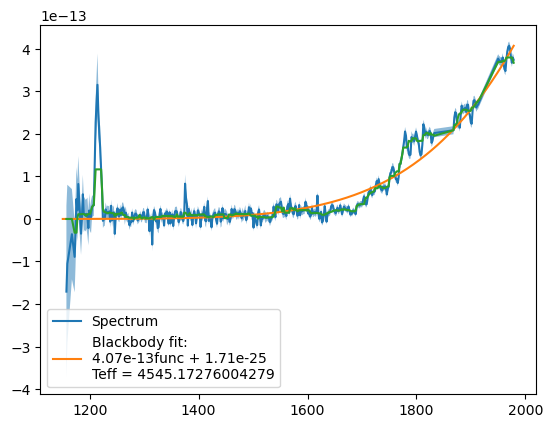

In [27]:
# Mask huge peaks in spectrum

w = 11
fit_teff = True

diff = rawflux[1:] - rawflux[:-1]
diff = np.append(diff, 0.)
std = np.std(diff)
mask = np.logical_and((diff <= 2*std), (diff >= -2*std))

x = wavelengths[mask]
y = rawflux[mask]
yerr = fluxerr[mask]

## Create smoothed version of spectrum

raw_flux_presmooth = Spectrum1D(flux = y * (u.erg/u.cm**2/u.s/u.AA), spectral_axis = x * u.AA)
smoothed_raw_flux = median_smooth(raw_flux_presmooth, w)

y_smooth = smoothed_raw_flux.flux


## Find and mask absorption lines in longer-wavelength section

absorp, __ = find_peaks(-y_smooth, prominence=np.median(y_smooth.value)+MAD(y_smooth.value))

bbmask = [True]*len(x)

for p in absorp:
    if x[p] > 1800.:
        bbmask[p-10:p+10] = [False]*20
        
x = x[bbmask]
y = y[bbmask]
yerr = yerr[bbmask]
y_smooth = y_smooth.value[bbmask]


## Fit blackbody curve to masked stellar spectrum

if fit_teff:
    popt, pcov = curve_fit(fitBB_fitTeff, x, y_smooth, p0=[Teff, 0., 0.],
                           sigma=yerr, absolute_sigma=True,
                           bounds=((3000., 0., 0.), (9000., y.max(), np.inf))) 
    
else:
    popt, pcov = curve_fit(lambda v, a, b: fitBB_fixedTeff(v, Teff, a, b), x, y_smooth, 
                           sigma=yerr, absolute_sigma=True,
                           bounds=((-np.inf, 0), (np.inf, np.inf))) 

## Plot masked spectrum and scaled blackbody curve

plt.plot(x, y, label='Spectrum')

if fit_teff:
    plt.plot(wavelengths, fitBB_fitTeff(wavelengths, popt[0], popt[1], popt[2]), 
             label=f'Blackbody fit:\n{popt[1]:0.2e}func + {popt[2]:0.2e}\nTeff = {popt[0]}')
else:
    plt.plot(wavelengths, fitBB_fixedTeff(wavelengths, Teff, popt[0], popt[1]), 
             label=f'Blackbody fit:\n{popt[0]:0.2e}func + {popt[1]:0.2e}\nTeff = {Teff}')

plt.fill_between( x, y-yerr, y+yerr, alpha=0.5 )
plt.plot(x, y_smooth)
plt.legend()


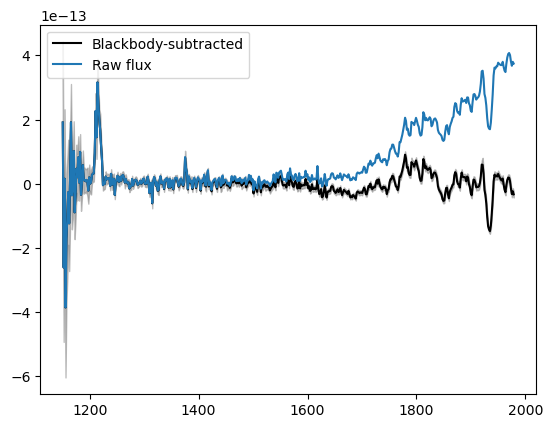

In [28]:
## Subtract BB curve

if fit_teff:
    flux = rawflux - fitBB_fitTeff(wavelengths, popt[0], popt[1], popt[2])
else:
    flux = rawflux - fitBB_fixedTeff(wavelengths, Teff, popt[0], popt[1])

## Plot BB-subtracted flux

plt.plot( wavelengths, flux, color='k', label='Blackbody-subtracted' )
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')

plt.plot( wavelengths, rawflux, label='Raw flux' )
plt.legend()

Text(0.5, 1.0, 'LOW-DISP SWP, F0-F2, SNR 2.39')

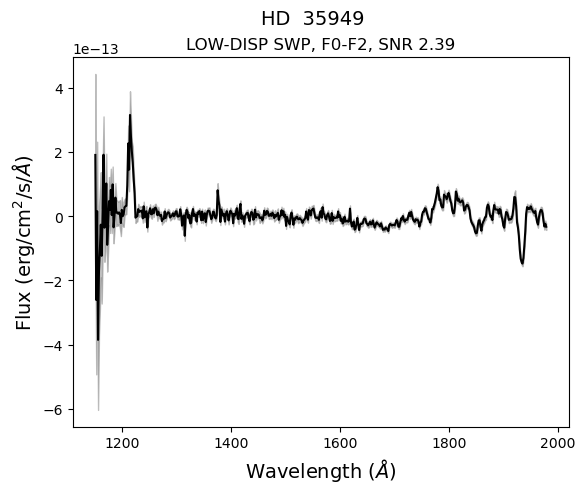

In [29]:
## Visualize BB-subtracted spectrum

# plt.tight_layout(rect=[0, 0.03, 1, 0.90])

plt.plot( wavelengths, flux, color='k', label='Blackbody-subtracted' )
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')

plt.xlabel(r'Wavelength ($\AA$)', fontsize=14)
plt.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

plt.suptitle(f'{starname}', fontsize=14)
plt.title(f'{dispersion}-DISP {camera}, {spclass}, SNR {snr}')

# plt.ylim(-.2*10**-13, .5*10**-13)
# plt.yscale('log')

In [40]:
## Save cleaned spectrum

# specDF = pd.DataFrame(data=np.array([wavelengths, flux, fluxerr]).T, columns=['Wavelengths', 'Flux', 'Fluxerr'])
# specDF.to_csv(f'{datapath}/{swpid}.csv', index=False)

In [41]:
# specDF = pd.read_csv('/Users/isabelkain/Desktop/GALEX/data/swp54894.csv')
# specDF['Wavelengths'].values

# Search for lines in spectrum

In [33]:
# from specutils.manipulation import box_smooth, median_smooth, gaussian_smooth, trapezoid_smooth

# w = 5
# raw_spectrum = Spectrum1D(flux = flux * (u.erg/u.cm**2/u.s/u.AA), spectral_axis = wavelengths * u.AA)
# spectrum = trapezoid_smooth(raw_spectrum, w)

# smoothed_spectrum_box = box_smooth(spectrum, w)
# smoothed_spectrum_med = median_smooth(spectrum, w)
# smoothed_spectrum_gaus = gaussian_smooth(spectrum, w)
# smoothed_spectrum_trap = trapezoid_smooth(spectrum, w)

# plt.figure(figsize=(12,4))

# plt.plot(spectrum.spectral_axis, spectrum.flux, color='k', label='Spectrum')
# plt.plot(smoothed_spectrum_box.spectral_axis, smoothed_spectrum_box.flux, label='Boxcar smoothed')
# plt.plot(smoothed_spectrum_med.spectral_axis, smoothed_spectrum_med.flux, label='Median smoothed')
# # plt.plot(smoothed_spectrum_gaus.spectral_axis, smoothed_spectrum_gaus.flux, label='Gaussian smoothed')
# plt.plot(smoothed_spectrum_trap.spectral_axis, smoothed_spectrum_trap.flux, color='tab:red', label='Trapezoid smoothed')

# plt.title(f'Smoothing width w = {w}')
# # plt.ylim(-.05*10**-12, 0.8*10**-12)
# plt.ylim(-.05*10**-12, 0.1*10**-12)

# plt.legend()
# plt.xlabel('Wavelength')
# plt.ylabel('Flux')

In [34]:

# plt.figure(figsize=(12,4))

# plt.plot(spectrum.spectral_axis, spectrum.flux, color='k', label='Spectrum')
# plt.plot(smoothed_spectrum.spectral_axis, smoothed_spectrum.flux, label='Median smoothed (w=35)')
# plt.plot(spectrum.spectral_axis, spectrum.flux-smoothed_spectrum.flux, label='Subtracted')

# # plt.ylim(-.05*10**-12, 0.8*10**-12)
# plt.ylim(-.05*10**-12, 0.1*10**-12)

# plt.legend()
# plt.xlabel('Wavelength')
# plt.ylabel('Flux')

In [35]:
# ## Create a Spectrum1D object, subtracting smoothed spectrum
# w = 5
# raw_spectrum = Spectrum1D(flux = flux * (u.erg/u.cm**2/u.s/u.AA), spectral_axis = wavelengths * u.AA)
# spectrum = trapezoid_smooth(raw_spectrum, w)

# ## Define the uncertainty of the spectrum using everything redward of the H line FIXME
# noise_region = SpectralRegion(np.floor(wavelengths[0])*u.AA, np.ceil(wavelengths[-1])*u.AA)
# spectrum = noise_region_uncertainty(spectrum, noise_region)

# thresh = np.median(np.abs(spectrum.flux.value)) + MAD(spectrum.flux.value) # use original, non-subtracted flux

# plt.figure(figsize=(12,4))
# plt.plot(raw_spectrum.spectral_axis, raw_spectrum.flux, color='k', label='OG spectrum')
# plt.plot(spectrum.spectral_axis, spectrum.flux, color='tab:red', label='Smoothed spectrum')
# plt.hlines( thresh, wavelengths.min(), wavelengths.max(), ls='--', label='Threshold' )

# plt.ylim(-.05*10**-12, 0.1*10**-12)
# plt.title('Smoothed spectrum (input for line identification routine)')
# plt.legend()

Flux threshold: 2.0462134e-14


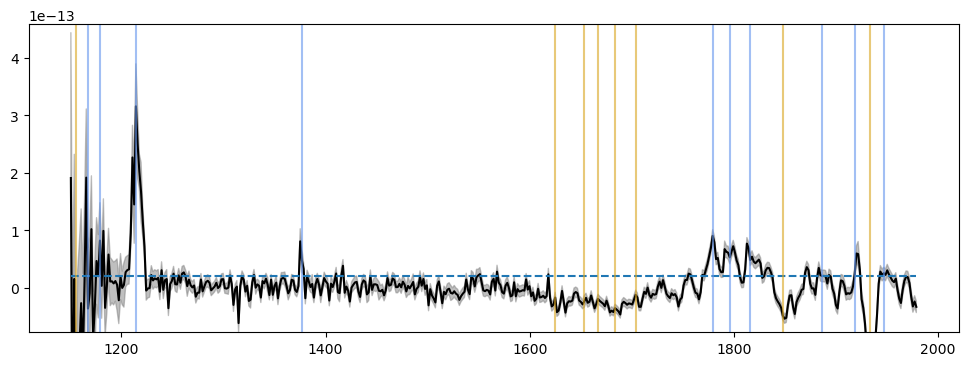

In [36]:
#####################################
## ID lines in spectrum            ##
#####################################

## Create a Spectrum1D object, subtracting smoothed spectrum
w = 5
raw_spectrum = Spectrum1D(flux = flux * (u.erg/u.cm**2/u.s/u.AA), spectral_axis = wavelengths * u.AA)
spectrum = trapezoid_smooth(raw_spectrum, w)

## Define the uncertainty of the spectrum using everything redward of the H line FIXME
noise_region = SpectralRegion(np.floor(wavelengths[0])*u.AA, np.ceil(wavelengths[-1])*u.AA)
spectrum = noise_region_uncertainty(spectrum, noise_region)


## Find lines using a noise threshold

with warnings.catch_warnings():

    warnings.simplefilter('ignore')

    thresh = np.median(np.abs(spectrum.flux.value)) + MAD(spectrum.flux.value)
#     thresh = 10*np.median(flux) # DONT USE this is for historical analysis reasons
    lines = find_lines_derivative(spectrum, thresh*(u.erg/u.cm**2/u.s/u.AA)) 
    print( 'Flux threshold:', thresh )

    
## Plot identified lines

plt.figure(figsize=(12,4))

plt.plot( wavelengths, flux, c='k')
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')
plt.hlines( thresh, wavelengths.min(), wavelengths.max(), ls='--' )

plt.ylim(0.2*flux.min(), 30*np.median(np.abs(flux)))
ymin, ymax = plt.ylim()


for l in lines:
    
    if l['line_type']=='emission':
        plt.vlines(l['line_center'].value, ymin, ymax, alpha=0.6, color='cornflowerblue')
    elif l['line_type']=='absorption':
        plt.vlines(l['line_center'].value, ymin, ymax, alpha=0.6, color='goldenrod')
    


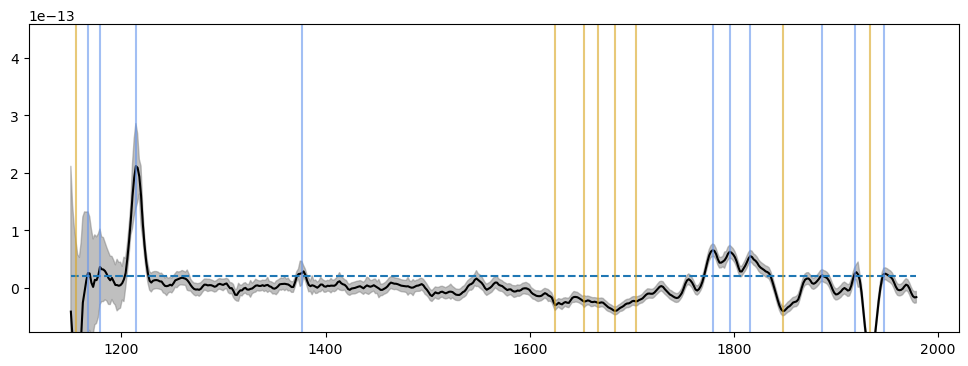

In [37]:
## Plot identified lines

plt.figure(figsize=(12,4))

plt.plot( spectrum.spectral_axis, spectrum.flux, c='k')
plt.fill_between(spectrum.spectral_axis.value, 
                 spectrum.flux.value + fluxerr, 
                 spectrum.flux.value - fluxerr, alpha=0.5, color='gray')
plt.hlines( thresh, spectrum.spectral_axis.value.min(), spectrum.spectral_axis.value.max(), ls='--' )

plt.ylim(0.2*flux.min(), 30*np.median(np.abs(flux)))
ymin, ymax = plt.ylim()


for l in lines:
    
    if l['line_type']=='emission':
        plt.vlines(l['line_center'].value, ymin, ymax, alpha=0.6, color='cornflowerblue')
    elif l['line_type']=='absorption':
        plt.vlines(l['line_center'].value, ymin, ymax, alpha=0.6, color='goldenrod')
    


## Reformat lines table

In [38]:
savelines = lines[lines['line_type']=='emission']
savelines['Peak label'] = np.round(savelines['line_center'].value).astype(int).astype(str)
savelines['Spectrum'] = np.full(len(savelines), '?')
savelines['Confident?'] = np.full(len(savelines), False)

savelines.write('/Users/isabelkain/Desktop/GALEX/data/swp54894_foundpeaks.ecsv', overwrite=True)
savelines

line_center,line_type,line_center_index,Peak label,Spectrum,Confident?
Angstrom,,,,,
float32,str10,int64,str21,str1,bool
1167.2552490234375,emission,10,1167,?,False
1178.989013671875,emission,17,1179,?,False
1214.1903076171875,emission,38,1214,?,False
1376.787109375,emission,135,1377,?,False
1779.0882568359375,emission,375,1779,?,False
1795.850830078125,emission,385,1796,?,False
1815.9658203125,emission,397,1816,?,False
1886.3685302734375,emission,439,1886,?,False


# Fit Gaussian profile to found peaks

0 True [False, False, False, True] 1 2.2452175980631637 0.4142603582645933
Fit failed. No line found.
1 True [False, False, False, True] 1 0.8035110254213578 2.517690587325477
Fit failed. No line found.
2 False [False, False, False, False] 1 0.8044601389922263 4.2831824947465025
Mask check:  16 16 16
3 False [False, False, False, False] 1 1.0855269979340392 1.1871626897014336
Mask check:  4 20 20
4 False [False, False, False, False] 1 1.1403458195511575 6.654659462566791
Mask check:  24 44 44
5 True [False, True, False, False] 1 4.318095723099987 3.8526228320187847
Fit failed. No line found.
6 False [False, False, False, False] 1 1.6128628666126588 8.079837353245459
Mask check:  29 69 69
7 False [False, False, False, False] 1 0.6987335292076295 4.748050811238447
Mask check:  17 86 86
8 False [False, False, False, False] 1 2.5337872437314672 1.672969467574827
Mask check:  6 92 92
9 False [False, False, False, False] 1 2.8949696031227177 3.809333416201706
Mask check:  14 106 106


line_center,line_type,line_center_index,peak_fit,peak_std
Angstrom,,,Angstrom,Angstrom
float32,str10,int64,float64,float64
1214.1903076171875,emission,38,1214.9947677561797,4.2831824947465025
1376.787109375,emission,135,1375.701582377066,1.1871626897014336
1779.0882568359375,emission,375,1780.2286026554887,6.654659462566791
1815.9658203125,emission,397,1817.5786831791127,8.079837353245459
1886.3685302734375,emission,439,1887.0672638026451,4.748050811238447
1918.217529296875,emission,458,1920.7513165406065,1.672969467574827
1946.7137451171875,emission,475,1949.6087147203102,3.809333416201706


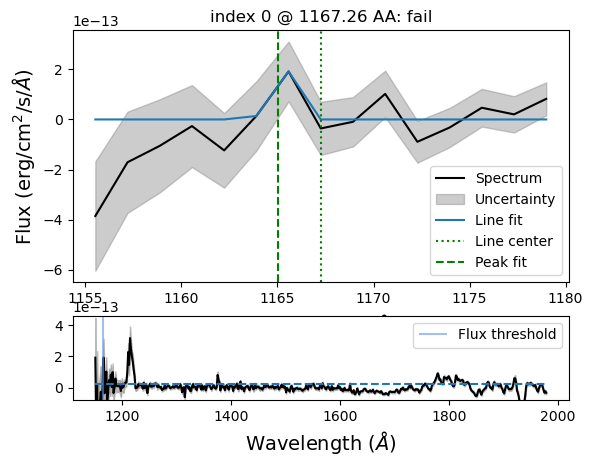

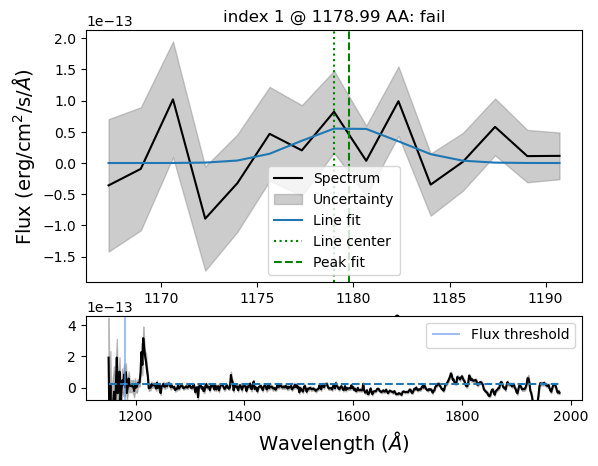

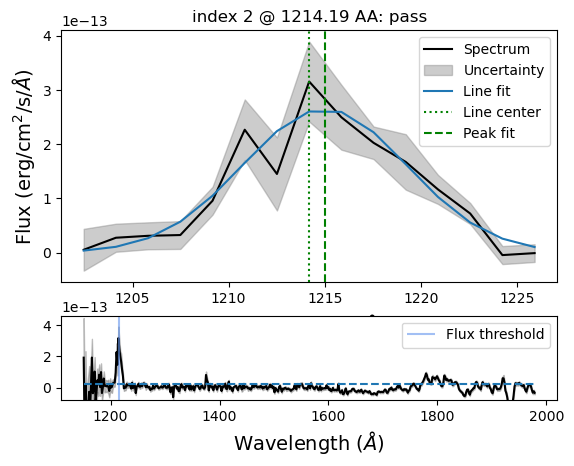

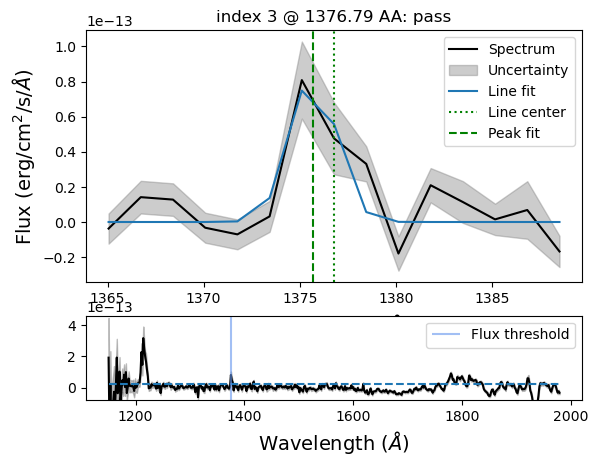

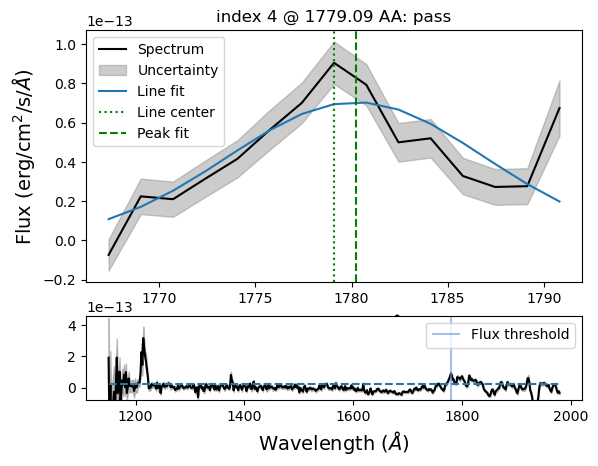

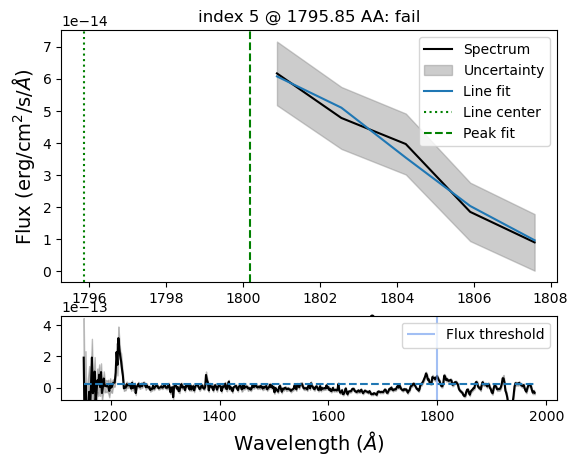

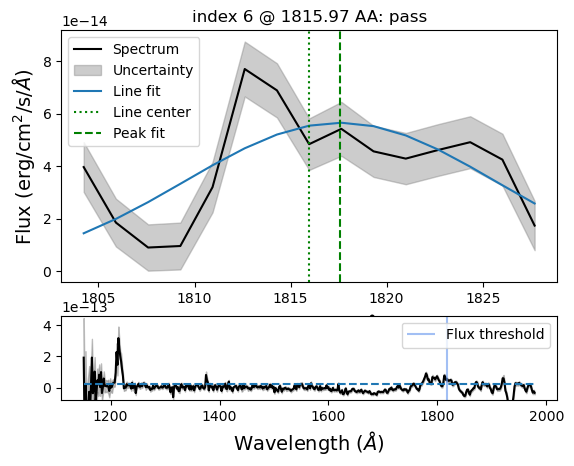

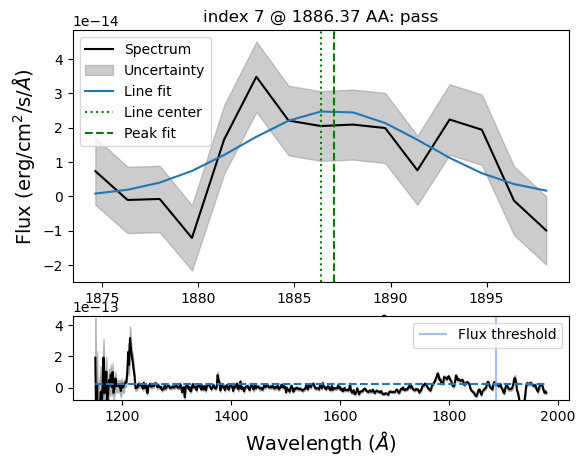

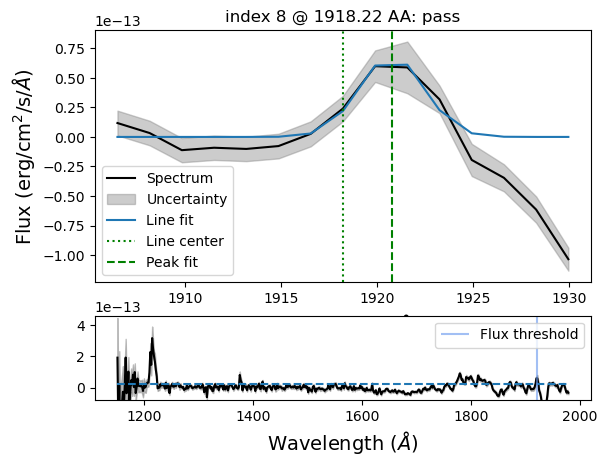

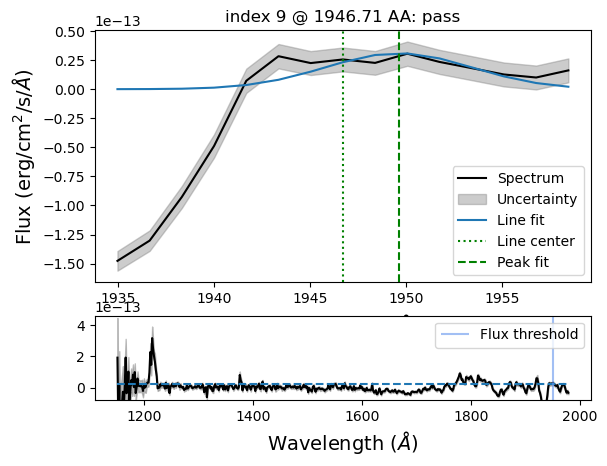

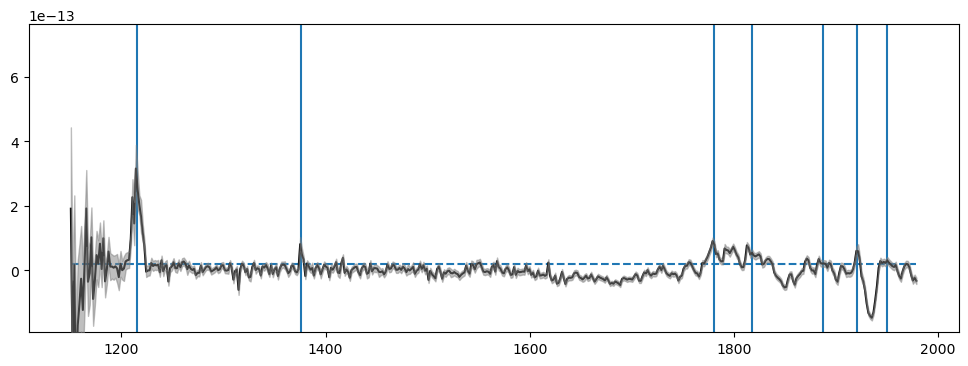

In [42]:
#####################################
## Fit Gaussian to line candidates ##
#####################################

'''
Lots of variables in here with related meanings.

spectrum:
    Spectrum1D object containing smoothed version of original data.
raw_spectrum:
    Spectrum1D object containing original data.
search_spectrum:
    Spectrum1D object containing a copy of spectrum, with already fitted lines masked out
window:
    Spectrum1D object, subset of spectrum (smoothed version) isolated around line being fitted.
x, y, yerr:
    unitless arrays containing x (wavelength), y (flux) and yerr (flux error) data from window
y_fit:
    astropy Quantity array containing Gaussian fit to isolated line
'''

## Create new columns in lines

lines['peak_fit'] = np.zeros(len(lines)) * u.AA
lines['peak_std'] = np.zeros(len(lines)) * u.AA


## Make copy of spectrum to mask lines as we fit them

search_spectrum = Spectrum1D(flux=raw_spectrum.flux, spectral_axis=raw_spectrum.spectral_axis) # use unsmoothed because smoothing shifts peak locations enough to be troublesome
search_spectrum.mask = [False]*len(search_spectrum.data)

###############################
## Fit Gaussian to each line ##
###############################

for i, cen in enumerate(lines[lines['line_type']=='emission']['line_center'].value):
    
    ## Set window around line center
    margin = 12. # AA
    ulim = cen - margin
    hlim = cen + margin
    
    # have to do this stupid shit because Spectrum1D doesn't ACTUALLY mask its data
    xmask = search_spectrum.spectral_axis.value[~search_spectrum.mask] 
    ymask = search_spectrum.flux.value[~search_spectrum.mask]
    yerrmask = fluxerr[~search_spectrum.mask]

    # Trim x and y arrays down to window around line
    trim = (xmask >= ulim) & (xmask < hlim)
    x = xmask[trim]
    y = ymask[trim]
    yerr = yerrmask[trim]

    window = Spectrum1D(flux=y*(u.erg/u.cm**2/u.s/u.AA), spectral_axis=x*u.AA)
    
    ## Initialize Gaussian model and fitter
    fitter = LevMarLSQFitter()
    g_init = models.Gaussian1D(amplitude=y.max() * (u.erg/u.cm**2/u.s/u.AA), 
                               mean=cen * u.AA, 
                               stddev=3.*u.AA)
    
    ## Fit model to window around line 
    g_fit = fit_lines(window, g_init, fitter=fitter)
    y_fit = g_fit(x * u.AA)


    #########################
    ## Acceptance criteria ##
    #########################
    
    ## Check if fit succeeded FIXME: rejecting everything after introducing smoothed input spectrum

    crit = [fitter.fit_info['ierr'] not in [1, 2, 3, 4], 
            np.abs( cen - g_fit.mean.value ) > 3., 
            g_fit.stddev.value <= 0.01, g_fit.mean.value < 1200.]
#             g_fit.stddev.value >= 4.0] ## stddev varies a lot with line type, unreliable metric
    fail = np.any(crit)
    print(i, fail, crit, fitter.fit_info['ierr'], np.abs( cen - g_fit.mean.value ), g_fit.stddev.value)

    if fail:
        print('Fit failed. No line found.')

    else:

        ## Mask line in search_spectrum
        line_center = g_fit.mean.value # AA
        line_stddev = g_fit.stddev.value
        
        line_lowlim = line_center - 3*line_stddev
        line_uplim = line_center + 3*line_stddev

        hideline = (search_spectrum.spectral_axis.value >= line_lowlim) & (search_spectrum.spectral_axis.value < line_uplim)
        oldmask = search_spectrum.mask
        
        search_spectrum.mask = np.logical_or(hideline, oldmask)
        print('Mask check: ', np.sum(hideline), np.sum(np.logical_or(hideline, oldmask)), np.sum(search_spectrum.mask) )

        
        ## Save peak wavelength
        j = np.argmin(np.abs(lines['line_center'] - cen * u.AA))
        lines[j]['peak_fit'] = g_fit.mean.value * u.AA
        lines[j]['peak_std'] = g_fit.stddev.value * u.AA

        
    #########################
    ## Plot results        ##
    #########################
    
    diagnostic_plots = True
    
    if diagnostic_plots:
        
        if fail: status = 'fail'
        else: status = 'pass'

        fig = plt.figure()
        gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1))

        # Plot isolated line and fit
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])

        ax1.plot( x, y, c='k', label='Spectrum' )
        ax1.fill_between( x, y-yerr, y+yerr, alpha=0.4, color='gray', label='Uncertainty' )
        ax1.plot( x, y_fit, label='Line fit' )
        ymin, ymax = ax1.set_ylim()

        ax1.vlines(cen, ymin, ymax, ls=':', color='g', label='Line center' )
        ax1.vlines(g_fit.mean.value, ymin, ymax, ls='--', color='g', label='Peak fit' )

        ax1.set_title(f'index {i} @ {cen:0.2f} AA: {status}')
        ax1.legend()
        ax1.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
        ax1.set_ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

        # Plot full spectrum with line annotated
        ax2.plot( wavelengths, flux, c='k' )
        ax2.fill_between( wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray' )
        ax2.hlines( thresh, wavelengths.min(), wavelengths.max(), ls='--' )
        
        ax2.set_ylim(0.2*flux.min(), 30*np.median(np.abs(flux)))
        ymin, ymax = ax2.set_ylim()

        ax2.vlines(g_fit.mean.value, ymin, ymax, alpha=0.6, color='cornflowerblue', label='Flux threshold')
        ax2.legend()
        ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)


        ## Save figure
        if not os.path.exists(f'{analysispath}/{swpid}_{objname}/linefit_plots'):
            os.mkdir(f'{analysispath}/{swpid}_{objname}/linefit_plots')
        
        plt.savefig(f'{analysispath}/{swpid}_{objname}/linefit_plots/{i}_{round(cen)}_{status}.png')
#         plt.close()
        
    
    
## Record successfully fit lines
goodlines = lines[lines['peak_fit']!=0.0*u.AA]
display(goodlines)


#########################
## Plot whole spectrum ##
#########################

plt.figure(figsize=(12,4))
plt.plot(wavelengths, flux, color='k', zorder=5)
plt.fill_between(wavelengths, flux-fluxerr, flux+fluxerr, alpha=0.5, color='gray', zorder=5)
plt.hlines( thresh, wavelengths.min(), wavelengths.max(), ls='--' )

plt.ylim(0.5*flux.min(), 50*np.median(np.abs(flux)))
ymin, ymax = plt.ylim()

for line in goodlines:
    plt.vlines(line['peak_fit'].value, ymin, ymax)
    
    
## Save figure
if not os.path.exists(f'{analysispath}/{swpid}_{objname}/linefit_plots'):
    os.mkdir(f'{analysispath}/{swpid}_{objname}/linefit_plots')

plt.savefig(f'{analysispath}/{swpid}_{objname}/linefit_plots/all_lines.png')


## Save table of found lines
columns=['NIST peak', 'Measured peak', 'Stddev', 'Peak label', 'Spectrum', 'Confident?']
rows = np.array([goodlines['line_center'], goodlines['peak_fit'], 
                 goodlines['peak_std'], np.round(goodlines['line_center'].value).astype(int),
                 np.full(len(goodlines), '?'), np.zeros(len(goodlines))]).T

linestable = pd.DataFrame(columns=columns, data=rows)
linestable.to_csv(f'{analysispath}/{swpid}_{objname}/linestable.csv', index=False)
    

In [51]:
display(goodlines)
display(linestable)

line_center,line_type,line_center_index,peak_fit,peak_std
Angstrom,,,Angstrom,Angstrom
float32,str10,int64,float64,float64
1214.1903076171875,emission,38,1214.9947677561797,4.2831824947465025
1376.787109375,emission,135,1375.701582377066,1.1871626897014336
1779.0882568359375,emission,375,1780.2286026554887,6.654659462566791
1815.9658203125,emission,397,1817.5786831791127,8.079837353245459
1886.3685302734375,emission,439,1887.0672638026451,4.748050811238447
1918.217529296875,emission,458,1920.7513165406065,1.672969467574827
1946.7137451171875,emission,475,1949.6087147203102,3.809333416201706


,NIST peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
0,1214.1903,1214.9947677561797,4.2831824947465025,1214,?,0.0
1,1376.7871,1375.701582377066,1.1871626897014336,1377,?,0.0
2,1779.0883,1780.2286026554887,6.654659462566791,1779,?,0.0
3,1815.9658,1817.5786831791127,8.079837353245459,1816,?,0.0
4,1886.3685,1887.0672638026451,4.748050811238447,1886,?,0.0
5,1918.2175,1920.7513165406065,1.672969467574827,1918,?,0.0
6,1946.7137,1949.6087147203102,3.809333416201706,1947,?,0.0


# Search NIST for matching lines

1202.1452202719402 1227.8443152404193 1214.9947677561797 12.849547484239508
Wavelength range:  1202.4565 1227.6005
No result for Cl
1372.1400943079616 1379.2630704461703 1375.701582377066 3.5614880691043007
Wavelength range:  1373.4346 1378.4634
No result for H
No result for He
No result for C
No result for N
1760.2646242677883 1800.192581043189 1780.2286026554887 19.963978387700372
Wavelength range:  1760.6494 1799.2032
No result for H
No result for He
1793.3391711193763 1841.818195238849 1817.5786831791127 24.239512059736377
Wavelength range:  1794.1746 1841.1096
No result for H
No result for He
1872.8231113689299 1901.3114162363604 1887.0672638026451 14.244152433715342
Wavelength range:  1872.9586 1899.7786
No result for H
No result for He
1915.732408137882 1925.770224943331 1920.7513165406065 5.018908402724481
Wavelength range:  1916.5411 1924.9224
No result for H
No result for He
No result for Si
No result for Ca
1938.1807144717052 1961.0367149689152 1949.6087147203102 11.42800024

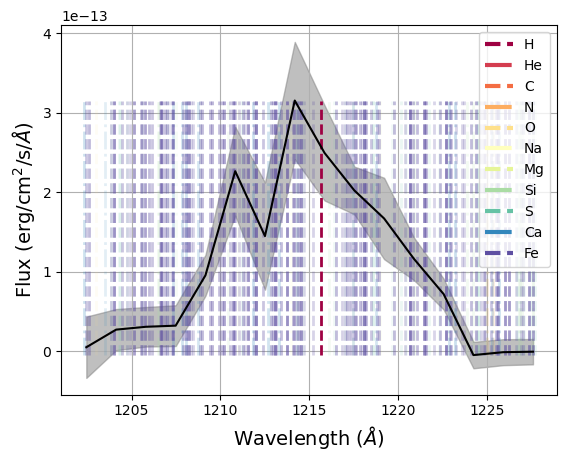

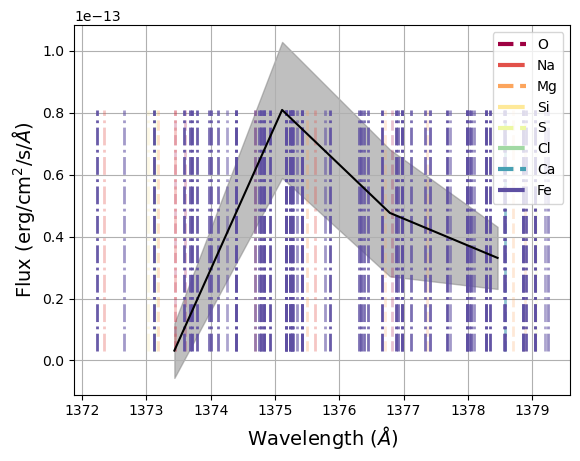

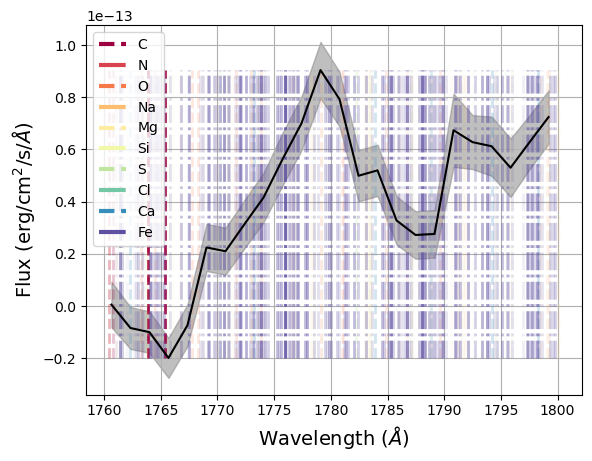

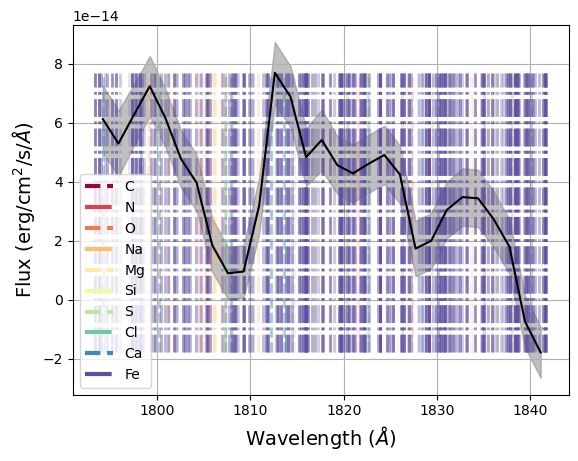

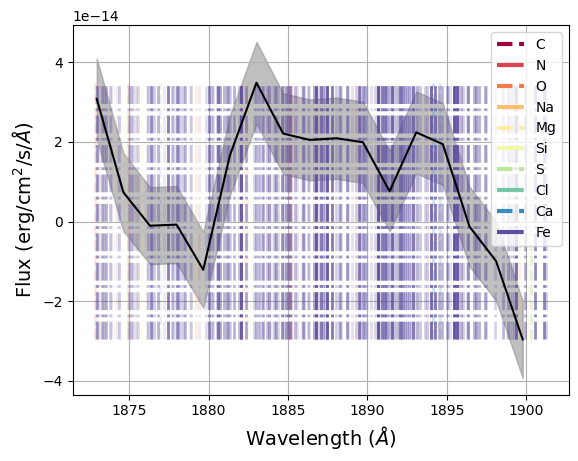

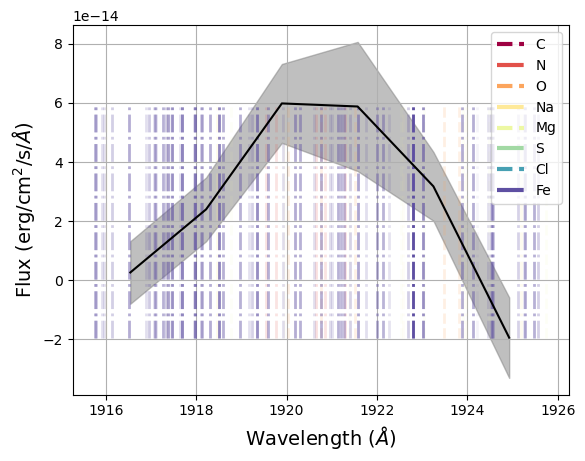

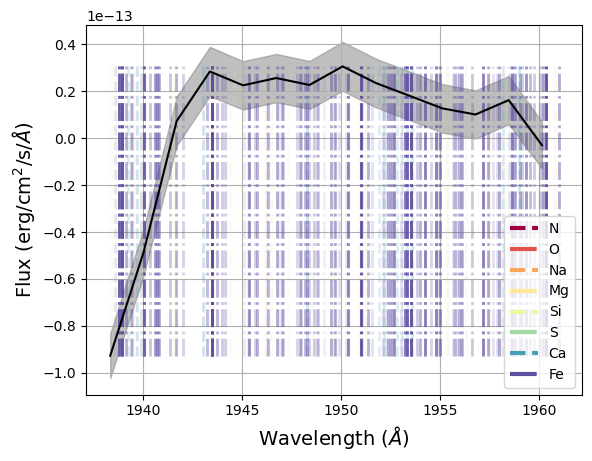

In [52]:
## Iterate through successfully identified lines

for i in range(len(linestable)):
    
    line = linestable.loc[i, :] ## Line is current row in linestable

    ## Set window around peak based on best-fit mean and stddev values

    margin = 3. * float(line['Stddev']) # AA
    peak = float(line['Measured peak'])
    ulim = peak - margin
    hlim = peak + margin
    print(ulim, hlim, peak, margin)

    trim = (wavelengths >= ulim) & (wavelengths <= hlim)
    x = wavelengths[trim]
    y = flux[trim]
    yerr = fluxerr[trim]
    print('Wavelength range: ', x.min(), x.max())


    #################################
    ## Query NIST for nearby lines ##
    #################################

    NISTresults = pd.DataFrame(columns=['Spectrum', 'Observed', 'Rel.', 'Acc.'])
    elements = ['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Cl', 'Ca', 'Fe']
    found_el = []

    for i, el in enumerate(elements):

        try:
            result = Nist.query(ulim * u.AA, hlim * u.AA, linename=f"{el}")

        except:
            print(f'No result for {el}')
            continue

        ## Count number of elements with matching lines
        found_el.append(i)

        ## Save line information

        try:    spec = result['Spectrum'].data
        except: spec = np.array([f'{el} I']*len(result))  # If NIST result has no Spectrum column, then only one ionization level exists

        newresult = pd.DataFrame( data={'Spectrum':spec, 
                                        'Observed':result['Observed'].data, 
                                        'Rel.':result['Rel.'].data.astype(str), 
                                        'Acc.':result['Acc.'].data} )

        newresult.dropna(axis=0, subset=['Observed', 'Rel.'], inplace=True)
        NISTresults = pd.concat([NISTresults, newresult], axis=0, ignore_index=True)


    ## Reformat relative intensities column (strip keyword info)
    NISTresults['Rel.'] = NISTresults['Rel.'].str.replace('[,()\/*a-zA-Z?:]', '', regex=True).str.strip()
    NISTresults['Rel.'] = NISTresults['Rel.'].str.replace('', '0', regex=True).str.strip()
    NISTresults['Rel.'] = NISTresults['Rel.'].astype(float)
    
#     display(NISTresults)

    ## Assess most likely line -- jk data is too shitty to do this
    # xyz


    #######################
    ## Visualize results ##
    #######################
    
    plt.figure()

    ## From list of indices, which elements had matching lines?
    ID_elements = [elements[i] for i in found_el]

    ## Set colormap, opacities for plotting
    cmap = mpl.colormaps['Spectral'] # gist_rainbow is clearer but uglier
    colors = cmap(np.linspace(0,1,len(ID_elements)))
    maxint = NISTresults['Rel.'].max()

    for i, el in enumerate(ID_elements):

        ## Isolate lines attributed to l, plot each one
        el_lines = NISTresults.loc[NISTresults['Spectrum'].str.contains(f'{el} ')]

        if i%2==0: ls = '--'
        else: ls = '-.'

        for j, l in el_lines.iterrows():
            plt.vlines(l['Observed'], y.min(), y.max(), 
                       alpha=(float(l['Rel.'])/maxint)**.1, ls=ls, lw=2, color=colors[i])

    ## Save legend handles
    handles = []

    for i in range(0, len(ID_elements)):

        if i%2==0: ls = '--'
        else: ls = '-.'

        handles = np.append( handles, Line2D([0],[0],color=colors[i], lw=3, ls=ls, label=f'{ID_elements[i]}') )


    ## Finish formatting plot
    plt.plot( x, y, c='k' )
    plt.fill_between( x, y-yerr, y+yerr, alpha=0.5, color='gray' )
    plt.legend(handles, ID_elements)
    plt.grid(True)
    plt.xlabel(r'Wavelength ($\AA$)', fontsize=14)
    plt.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

    ## Save figure
    if not os.path.exists(f'{analysispath}/{swpid}_{objname}/lineID_plots'):
        os.mkdir(f'{analysispath}/{swpid}_{objname}/lineID_plots')

    plt.savefig(f'{analysispath}/{swpid}_{objname}/lineID_plots/{round(peak)}.png')
    
    ## Save table
    if not os.path.exists(f'{analysispath}/{swpid}_{objname}/lineID_tables'):
        os.mkdir(f'{analysispath}/{swpid}_{objname}/lineID_tables')

    NISTresults.to_csv(f'{analysispath}/{swpid}_{objname}/lineID_tables/{round(peak)}.csv', index=False)
    
    # plt.close()


In [53]:
NISTresults

,Spectrum,Observed,Rel.,Acc.
0,O II,1957.4410,1.000000e+03,C
1,O II,1958.1220,8.000000e+01,C
2,O II,1960.2650,1.000000e+03,C
3,Na III,1938.4100,4.000000e+01,NaN
4,Na III,1938.6370,6.000000e+01,C
...,...,...,...,...
173,Fe I,1960.1439,6.020000e+05,NaN
174,Fe III,1960.1570,4.040000e+09,D
175,Fe III,1960.3250,1.050000e+13,B
176,Fe I,1960.6210,0.000000e+00,NaN


In [65]:
result['Observed'].value[-11].data

array(0.)

# Interactive results

## Popup window

In [61]:
def line_popup(swpid, objname, starname, cen):
    '''
    Generate popup window for user to ID spectral line.
    Inputs:
    swpid [str]: SWP ID of observation, e.g. swp54894
    objname [str]: colloquial name of object no spaces, e.g. *gamMic
    cen [int]: rounded wavelength of line being ID'd, e.g. 1216
    '''
    
    sg.theme('BlueMono')
    modal=True
    
    ## Define paths to line snapshot and NIST line results
    imgpath = f'{analysispath}/{swpid}_{objname}/lineID_plots/{str(cen)}.png'
    tablepath = f'{analysispath}/{swpid}_{objname}/lineID_tables/{str(cen)}.csv'

    ## Load table of good lines identified by fitting routine
    linetable = pd.read_csv(f'{analysispath}/{swpid}_{objname}/linestable.csv')

    ## Find row matching line indicated by cen
    loc = linetable.index[linetable['Peak label'] == cen].tolist()[0]

    ## Load table of possible lines queried from NIST
    tbl = pd.read_csv(tablepath)
    tbl_list = tbl.values.tolist()
    tbl_cols = list(tbl.columns.values)


    ## Define layout of window
    col1 = [[sg.Image(imgpath)],
            [sg.Text('Spectrum:')],
            [sg.Input(default_text = f"{linetable.loc[loc,'Spectrum']}", key='-SPECTRUM-')],
            [sg.Checkbox('Confident?', default=True, key='-CONFIDENT-')],
            [sg.Button('Ok'), sg.Button('Cancel')] ]
    col2 = [sg.Table(tbl_list, headings = tbl_cols)]
    layout = [[col1, col2]]

    # Create the Window
    window = sg.Window('Spectral line identification', layout)

    while True:
        event, values = window.read()
        print(event, values)
        if event == sg.WIN_CLOSED or event == 'Cancel':
            break

        if event == 'Ok':
            ## Record spectrum and confidence data
            linetable.loc[loc, 'Spectrum']   = values['-SPECTRUM-']
            linetable.loc[loc, 'Confident?'] = values['-CONFIDENT-']
            break

    window.close()

    ## Write changes
    linetable.to_csv(f'{analysispath}/{swpid}_{objname}/linestable.csv', index=False)
    
    return 0


def plot_spectrum(swpid, objname):
    '''
    Save png of full spectrum of object with lines annotated.
    Inputs:
    swpid [str]: SWP ID of observation, e.g. swp54894
    objname [str]: colloquial name of object no spaces, e.g. *gamMic
    '''
    
    ## Load spectrum
    spectrum = pd.read_csv(f'{datapath}/{swpid}.csv')
    
    ## Load table of good lines identified by fitting routine
    linetable = pd.read_csv(f'{analysispath}/{swpid}_{objname}/linestable.csv')
    centers = linetable['Peak label'].values
    peakvals = linetable['Measured peak'].values
    linespecs = linetable['Spectrum'].values

    for i in range(len(linespecs)):
        if (linespecs[i]!='?') & (linetable['Confident?'][i]==False):
            linespecs[i] = linespecs[i] + '?'


    ## Plot spectrum
    fig = plt.figure(figsize=(12,4))
    plt.plot(spectrum['Wavelengths'], spectrum['Flux'])
    plt.fill_between(spectrum['Wavelengths'], spectrum['Flux']-spectrum['Fluxerr'], 
                     spectrum['Flux']+spectrum['Fluxerr'], alpha=0.5)

    ymin, ymax = plt.ylim()

    for i, peak in enumerate(peakvals):
        plt.axvline(peak, color='#B488D3')
        plt.annotate( linespecs[i], xy=(peak+5, 0.85*ymax), color='#713e95', fontsize=14 )

    plt.savefig(f'{analysispath}/{swpid}_{objname}/analyzed_spectrum.png')
    plt.close()

    return 0
    
    
    
def spectrum_popup(swpid, objname, starname):
    '''
    Generate popup window that shows full spectrum of given object, with found lines annotated.
    Inputs:
    swpid [str]: SWP ID of observation, e.g. swp54894
    objname [str]: colloquial name of object no spaces, e.g. *gamMic
    starname [str]: colloquial name of object, e.g. * gam Mic
    '''

    modal=False

    
    ## Plot figure
    imgpath = f'{analysispath}/{swpid}_{objname}/analyzed_spectrum.png'
    plot_spectrum(swpid, objname)


    ## Make buttons
    labels = np.array([fr'{centers[i]} A' for i in range(len(centers))])
    buttons = []

    for l in labels:
        b = sg.Button(l)
        buttons.append(b)


    ## Make image
    img = sg.Image(imgpath, key='-SPECTRUM-')


    ## Window layout
    layout = [[img], [sg.Text('Identify lines:'), *buttons], [sg.Button('Close')]]


    ## Make window
    window = sg.Window(f'{starname} spectrum', layout, finalize=True, element_justification='center', font='Helvetica 18')

    while True:

        event, values = window.read()
        print(event, values)

        if event == sg.WIN_CLOSED or event == 'Close':
            break

        if np.any(event == labels):

            ## Call popup for individual line
            cen = int(re.sub(" [a-zA-Z]", "", event))
            line_popup(swpid, objname, starname, cen)

            ## Replot spectrum
            plot_spectrum(swpid, objname)

            ## Update spectrum in window
            img.update(imgpath)

    return 0



## Bokeh plot

In [51]:
goodlines

line_center,line_type,line_center_index,peak_fit,peak_std
Angstrom,,,Angstrom,Angstrom
float32,str10,int64,float64,float64
1215.8912353515625,emission,39,1216.3287886507176,3.1295617916295893
1304.734619140625,emission,92,1306.1210282577183,3.1918620430366746
1396.9305419921875,emission,147,1395.0725070796366,1.7742290058466643
1547.79638671875,emission,237,1549.05970380962,3.2394301204871563
1639.9923095703125,emission,292,1642.0903195282565,1.5559649262060058
1660.10791015625,emission,304,1659.1603477317158,2.4560037652436457
1681.8995361328125,emission,317,1684.3646470645765,3.0221585942273443
1817.678955078125,emission,398,1818.4866244176326,2.273599584160695


In [63]:
linestable

,NIST peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
0,1215.8912,1216.3287886507176,3.1295617916295893,1216,?,0.0
1,1304.7346,1306.1210282577183,3.1918620430366746,1305,?,0.0
2,1396.9305,1395.0725070796366,1.7742290058466643,1397,?,0.0
3,1547.7964,1549.05970380962,3.2394301204871563,1548,?,0.0
4,1639.9923,1642.0903195282565,1.5559649262060058,1640,?,0.0
5,1660.1079,1659.1603477317158,2.4560037652436457,1660,?,0.0
6,1681.8995,1684.3646470645765,3.0221585942273443,1682,?,0.0
7,1817.679,1818.4866244176326,2.273599584160695,1818,?,0.0
8,1924.9614,1925.0125994715593,3.302202873135449,1925,?,0.0


## This is the actual working cell

In [108]:
# ## Plot spectrum

# p = figure(title=f"Spectrum for {starname} ({swpid}, {spclass}, SNR = {snr})", 
#            y_axis_label=r"Flux (erg/cm^2/s/A)", 
#            x_axis_label=r"Wavelength (Angstrom)", sizing_mode='stretch_width')

# p.line(wavelengths, flux, line_width=2)
# p.varea(x=wavelengths, y1=flux-fluxerr, y2=flux+fluxerr, fill_color="gray", alpha=0.5)



# ## Add slider for each identified peak

# sliders = []
# del_buttons = []

# for i in range(len(savelines)):
    
#     slider = Slider(start=wavelengths[0], end=wavelengths[-1], 
#                     value=float(savelines['line_center'][i].value), 
#                     step=0.01, title=savelines['Peak label'][i], width=500)
#     span = Span(location=slider.value, dimension='height', line_color="#B488D3", line_dash='dashed')
#     p.add_layout(span)

#     callback = CustomJS(args=dict(span=span), code="""
#         span.location = cb_obj.value
#     """)
#     slider.js_on_change('value', callback)
    
#     sliders.append(slider)
    
    
    
# ## Add 5 extra sliders for user input:

# user_sliders = []

# for i in range(5):
    
#     slider = Slider(start=wavelengths[0], end=wavelengths[-1], 
#                     value=wavelengths[-1], 
#                     step=0.01, title=f'User line {i+1}', width=500)
#     span = Span(location=slider.value, dimension='height', line_color="#B488D3", line_dash='dashed')
#     p.add_layout(span)

#     callback = CustomJS(args=dict(span=span), code="""
#         span.location = cb_obj.value
#     """)
#     slider.js_on_change('value', callback)
    
#     user_sliders.append(slider)
    
    
    
# ## Save slider values

# slider_values = []
# for S in sliders + user_sliders:
#     slider_values.append( S.value )

    
    
# ## Add "Save results" button

# span_results = []

# BTcallback = CustomJS(args=dict(sliders=sliders, results=span_results), code="""
#     for (var i = 0, _pj_a = sliders.length; i < _pj_a; i += 1) {
#       span_results.push(sliders[i].value);
#     }
# """)

# button = Button(label='Save inputs', button_type='success', align='center')
# button.js_on_event(ButtonClick, BTcallback)


# ## Make and format layout

# row2 = row(column(*sliders, sizing_mode='scale_width'), 
#            column(*user_sliders, sizing_mode='scale_width'), sizing_mode='scale_width')   
# layout = column(p, row2, button, sizing_mode='scale_width')
# curdoc().add_root(layout)

# show(layout)

# print(span_results)

[]


In [118]:
# ## TWO-SLIDER TEST

# slider_slope = Slider(start = 0, end = 1, value = 0.5, step = 0.1)
# slider_intercept = Slider(start = 0, end = 20, value = 10, step = 1)

# slider_code = '''   i = slider_intercept.value
#                     s = slider_slope.value
#                     x = r.data_source.data['x'];
#                     y = [];

#                     for (index = 0; index < x.length; index ++)
#                         y.push((s * x[index]) + i);

#                     r.data_source.data['y'] = y
#                     r.data_source.change.emit(); '''

# s = slider_slope.value  # slope.
# i = slider_intercept.value  # intercept.

# x = np.linspace(-40, 20, 200)
# y = [(s * xx + i) for xx in x]

# p = figure(title = "simple line example", y_range = Range1d(start = -80, end = 40), background_fill_color = '#efefef')
# r = p.line(x, y, color = "red", line_width = 1.5, alpha = 0.8)  # 1st line. This line can be controlled by sliders.
# q = p.line(x, 2 * x + 1.2, color = "blue", line_width = 1.9, alpha = 0.2)  # 2nd line.

# slider_callback = CustomJS(args = dict(slider_slope = slider_slope,
#                                 slider_intercept = slider_intercept,
#                                 r = r), code = slider_code)

# slider_slope.js_on_change('value', slider_callback)
# slider_intercept.js_on_change('value', slider_callback)

# layout = column(p, slider_slope, slider_intercept)
# show(layout, notebook_handle = True)

In [62]:
test = Table.read('/Users/isabelkain/Desktop/GALEX/data/swp54894_foundpeaks.ecsv')
# test['line_center'].value
test

line_center,line_type,line_center_index,Peak label,Spectrum,Confident?
Angstrom,,,,,
float32,str8,int64,str4,str1,bool
1180.6892,emission,18,1181,?,False
1215.8912,emission,39,1216,?,False
1234.3304,emission,50,1234,?,False
1304.7346,emission,92,1305,?,False
1396.9305,emission,147,1397,?,False
1547.7964,emission,237,1548,?,False
1639.9923,emission,292,1640,?,False
1660.1079,emission,304,1660,?,False


In [63]:
columns=['Approx peak', 'Measured peak', 'Stddev', 'Peak label', 'Spectrum', 'Confident?']
rows = np.array([test['line_center'].value, 
                 test['line_center'].value, 
                 np.zeros(len(test)), 
                 np.round(test['line_center'].value).astype(int),
                 np.full(len(test), '?'), 
                 np.zeros(len(test))]).T
pdtest = pd.DataFrame(columns=columns, data=rows)

pdtest

,Approx peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
0,1180.6892,1180.6892,0.0,1181,?,0.0
1,1215.8912,1215.8912,0.0,1216,?,0.0
2,1234.3304,1234.3304,0.0,1234,?,0.0
3,1304.7346,1304.7346,0.0,1305,?,0.0
4,1396.9305,1396.9305,0.0,1397,?,0.0
5,1547.7964,1547.7964,0.0,1548,?,0.0
6,1639.9923,1639.9923,0.0,1640,?,0.0
7,1660.1079,1660.1079,0.0,1660,?,0.0
8,1681.8995,1681.8995,0.0,1682,?,0.0
9,1817.679,1817.679,0.0,1818,?,0.0


In [64]:
pdtest.loc[:5, 'Measured peak'] = 0
pdtest

,Approx peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
0,1180.6892,0,0.0,1181,?,0.0
1,1215.8912,0,0.0,1216,?,0.0
2,1234.3304,0,0.0,1234,?,0.0
3,1304.7346,0,0.0,1305,?,0.0
4,1396.9305,0,0.0,1397,?,0.0
5,1547.7964,0,0.0,1548,?,0.0
6,1639.9923,1639.9923,0.0,1640,?,0.0
7,1660.1079,1660.1079,0.0,1660,?,0.0
8,1681.8995,1681.8995,0.0,1682,?,0.0
9,1817.679,1817.679,0.0,1818,?,0.0


In [65]:
pdtest[pdtest['Measured peak'] != 0.]

,Approx peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
6,1639.9923,1639.9923,0.0,1640,?,0.0
7,1660.1079,1660.1079,0.0,1660,?,0.0
8,1681.8995,1681.8995,0.0,1682,?,0.0
9,1817.679,1817.679,0.0,1818,?,0.0
10,1924.9614,1924.9614,0.0,1925,?,0.0
11,1951.782,1951.782,0.0,1952,?,0.0
12,1970.2212,1970.2212,0.0,1970,?,0.0


In [54]:
test2 = Table.read('/Users/isabelkain/Desktop/GALEX/data/swp54894_foundpeaks_test.ecsv')
test2

line_center,line_type,line_center_index,Peak label,Spectrum,Confident?,Measured
Angstrom,,,,,,
float32,str8,int64,str4,str1,bool,float64
1180.6892,emission,18,1181,?,False,0.0
1215.8912,emission,39,1216,?,False,1215.8912353515625
1234.3304,emission,50,1234,?,False,1234.3304443359375
1304.7346,emission,92,1305,?,False,1304.734619140625
1396.9305,emission,147,1397,?,False,1396.9305419921875
1547.7964,emission,237,1548,?,False,1547.79638671875
1639.9923,emission,292,1640,?,False,1639.9923095703125
1660.1079,emission,304,1660,?,False,1660.10791015625


In [66]:
pdtest2 = pd.read_csv(f'{analysispath}/{swpid}_{objname}/NISTlines_table_TEST.csv')
pdtest2

,Approx peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
0,1180.6892,0.000000,0.0,1181,?,0.0
1,1215.8912,1215.891235,0.0,1216,?,0.0
2,1234.3304,0.000000,0.0,1234,?,0.0
3,1304.7346,1304.734619,0.0,1305,?,0.0
4,1396.9305,1396.930542,0.0,1397,?,0.0
5,1547.7964,1547.796387,0.0,1548,?,0.0
6,1639.9923,1639.992310,0.0,1640,?,0.0
7,1660.1079,1660.107910,0.0,1660,?,0.0
8,1681.8995,1681.899536,0.0,1682,?,0.0
9,1817.6790,1817.678955,0.0,1818,?,0.0


In [69]:
pdtest2[pdtest2['Measured peak'] != 0]

,Approx peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
1,1215.8912,1215.891235,0.0,1216,?,0.0
3,1304.7346,1304.734619,0.0,1305,?,0.0
4,1396.9305,1396.930542,0.0,1397,?,0.0
5,1547.7964,1547.796387,0.0,1548,?,0.0
6,1639.9923,1639.992310,0.0,1640,?,0.0
7,1660.1079,1660.107910,0.0,1660,?,0.0
8,1681.8995,1681.899536,0.0,1682,?,0.0
9,1817.6790,1817.678955,0.0,1818,?,0.0
13,0.0000,1810.656000,0.0,0,?,0.0


In [72]:
for i in range(len(pdtest2)):
    print(pdtest2.loc[i, 'Measured peak'])

0.0
1215.8912353515625
0.0
1304.734619140625
1396.9305419921875
1547.79638671875
1639.9923095703125
1660.10791015625
1681.8995361328125
1817.678955078125
0.0
0.0
0.0
1810.656
0.0
0.0
0.0
0.0


In [80]:
os.system("bokeh serve --show bokehplot.py")
print('Arrived')

2022-12-25 09:51:38,131 Starting Bokeh server version 3.0.2 (running on Tornado 6.2)
2022-12-25 09:51:38,410 User authentication hooks NOT provided (default user enabled)
2022-12-25 09:51:38,413 Bokeh app running at: http://localhost:5006/bokehplot
2022-12-25 09:51:38,413 Starting Bokeh server with process id: 5710
2022-12-25 09:51:39,576 /Users/isabelkain/Desktop/GALEX/code/bokehplot.py: call to show() ignored when running scripts with the 'bokeh' command.
2022-12-25 09:51:39,756 WebSocket connection opened
2022-12-25 09:51:39,757 ServerConnection created
2022-12-25 09:51:58,936 WebSocket connection closed: code=1001, reason=None


Arrived


In [82]:
# from psutil import process_iter
# from signal import SIGTERM # or SIGKILL

# for proc in process_iter():
#     for conns in proc.connections(kind='inet'):
#         if conns.laddr.port == 5006:
#             proc.send_signal(SIGTERM)

In [83]:
import subprocess

In [106]:
output_stream = os.popen('lsof -i tcp:5006')
# print(output_stream)

pid = output_stream.read().split('\n')[1].split(' ')[1]
print(pid)
# # os.system(f'kill -9 {pid}')

In [111]:
output_stream = os.popen('lsof -i tcp:5006')
outlines = output_stream.read().split('\n')
for ol in outlines:
    if 'TCP *:wsm-server (LISTEN)' in ol:
        pid = ol.split(' ')[1]
        print(pid)

6651
6651


In [113]:
os.getcwd()

'/Users/isabelkain/Desktop/GALEX/code'

In [115]:
table['Run'] = np.full(len(table), True)

table

main_id,main_type,sp_type,obs_id,s_ra,s_dec,RAJ2000,DEJ2000,ra,dec,t_min,t_max,t_exptime,obs_title,jpegURL,dataURL,RAfdeg,DEfdeg,FUVexp,NUVexp,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fflux,e_Fflux,Nflux,e_Nflux,coo_qual,coo_bibcode,other_types,radvel,radvel_err,redshift,redshift_err,plx,plx_err,pmra,pmdec,B,V,R,J,H,K,u,g,r,i,z,FLUX_B,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_QUAL_V,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_QUAL_R,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_QUAL_I,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_QUAL_J,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_QUAL_K,TYPED_ID,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,SP_TYPE,SP_QUAL,OTYPE,V__vartyp,V__LoVmax,V__Vmax,V__R_Vmax,V__magtyp,V__UpVmin,V__Vmin,V__R_Vmin,V__UpPeriod,V__period,V__R_period,V__epoch,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,Distance_distance,Distance_unit,Distance_merr,Distance_perr,Distance_method,IUE type,Run
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,,,mag,,,,mag,,,,mag,,,,mag,,,,,unit-degK,cm / s2,,,,km / s,,,,,,,,,mag,,,,mag,,,d,,d,mas,,mas,,,,,,,,
str23,str19,str18,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str114,str74,str64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,str1,str19,str33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,object,int32,float32,float32,str1,str1,float32,float32,int32,str1,object,str1,object,str4,str1,float32,str1,str1,str1,float32,str1,str1,float64,str1,float64,float64,int16,float32,str1,float64,str2,float64,float64,str5,str34,bool
* gam Mic,Star,G8III,swp54894,315.3224724693,-32.2577449364,315.322853,-32.257566,315.3227519696,-32.2577659353,49875.41707,49875.45873,3599.844,IUE Survey of X-Ray Selected Late-Type Stars,http://archive.stsci.edu/browse/previews/iue/mx/swp/54000/gif/swp54894.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp54894mxlo_vo.fits,315.444385,-32.448868,157.0,157.0,17.2783,0.0402,12.2301,0.0027,0,2,0,0,445.323,16.4837,46554.0,117.279,A,2007A&A...474..653V,*|**|IR|UV|X,17.5,0.36,5.84e-05,1.2e-06,14.24,0.26,-1.73,0.41,5.529,4.654,--,3.15,2.713,2.596,--,--,--,--,--,5.529,0.009,Vega,D,--,--,,--,--,--,,--,3.15,0.010,Vega,B,2.596,0.010,Vega,B,* gam Mic,5310,3.0000,-0.010,--,--,--,--,0,--,G8III,C,Star,--,--,--,--,--,--,--,--,--,--,--,--,14.240,2,0.26,A,68.2929,pc,-2.3161,2.3161,paral,G III-I,True
HD 2454,PM*,F5VSr,swp55292,7.083429661399975,10.1900690724,7.083387,10.189901,7.0835103411,10.1898049067,49914.07061,49914.09145,1799.522,The White Dwarf Luminosity Function in F-K Binaries,http://archive.stsci.edu/browse/previews/iue/mx/swp/55000/gif/swp55292.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp55292mxlo_vo.fits,7.182728,10.038623,215.0,215.0,15.2804,0.0112,11.7018,0.0018,0,2,0,0,2804.53003,29.043,75731.89844,123.038,A,2020yCat.1350....0G,*|IR|PM*|Ro*|UV,-8.62,0.2,-2.88e-05,7e-07,26.2526,0.057,42.022,-180.181,6.47,--,5.8,5.201,5.057,4.942,--,--,--,--,--,6.47,--,,--,5.8,--,Vega,E,--,--,,--,5.201,0.037,Vega,C,4.942,0.020,Vega,C,HD 2454,6501,4.1100,-0.350,--,--,--,--,0,--,F5VSr,C,HighPM*,ROT,--,--,--,--,--,--,--,--,3.000000,--,--,26.253,3,0.057,A,38.0910,pc,-0.0827,0.0827,paral,F3-F9,True
* ksi01 Lib,PM*,K0III,swp55297,223.59536528340004,-11.8983649295,223.595816,-11.898603,223.5953088134,-11.8983503771,49914.87583,49914.92235,4019.145,--,http://archive.stsci.edu/browse/previews/iue/mx/swp/55000/gif/swp55297.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp55297mxlo_vo.fits,223.657823,-11.517354,89.0,90.0,20.5984,0.3548,13.6332,0.0069,256,0,0,0,20.9243,6.83601,12785.2002,81.2597,A,2020yCat.1350....0G,*|IR|PM*,-23.8,2.0,-7.94e-05,6.7e-06,9.867,0.0563,-53.095,-8.339,6.768,5.788,--,4.231,3.635,3.608,-

In [122]:
table['Run user peaks'] = [True]*len(table)
table['Run user NIST'] = [True]*len(table)
table.remove_column('Run')

In [126]:
# table = Table.read('/Users/isabelkain/Desktop/GALEX/data/dataset.ecsv')
table.write('/Users/isabelkain/Desktop/GALEX/data/dataset.ecsv', overwrite=True)
table.write('/Volumes/Seagate/seagate_backup/GALEX/data/dataset.ecsv', overwrite=True)

In [130]:
##pdtest2['Peak label'].values

array([1181, 1216, 1234, 1305, 1397, 1548, 1640, 1660, 1682, 1818, 1925,
       1952, 1970,    0,    0,    0,    0,    0])

In [138]:
## DELETE linestable.csv files, rename NISTlines_table.csv to linestable.csv

for i, swpid in enumerate(tqdm(table['obs_id'])):
    
    objname = table[i]['main_id'].replace(' ','')
    
    if glob.glob(f'{analysispath}/{swpid}_{objname}/NISTlines_table.csv') != 0:
        try:
            os.remove(f'{analysispath}/{swpid}_{objname}/linestable.csv')
        except:
            pass
        try:
            os.rename(f'{analysispath}/{swpid}_{objname}/NISTlines_table.csv', 
                      f'{analysispath}/{swpid}_{objname}/linestable.csv')
        except:
            pass
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 1558.71it/s]


In [139]:
pdtest2

,Approx peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
0,1180.6892,0.000000,0.0,1181,?,0.0
1,1215.8912,1215.891235,0.0,1216,?,0.0
2,1234.3304,0.000000,0.0,1234,?,0.0
3,1304.7346,1304.734619,0.0,1305,?,0.0
4,1396.9305,1396.930542,0.0,1397,?,0.0
5,1547.7964,1547.796387,0.0,1548,?,0.0
6,1639.9923,1639.992310,0.0,1640,?,0.0
7,1660.1079,1660.107910,0.0,1660,?,0.0
8,1681.8995,1681.899536,0.0,1682,?,0.0
9,1817.6790,1817.678955,0.0,1818,?,0.0


In [147]:
cols = np.array(['Approx peak', 'Measured peak', 'Stddev', 'Peak label', 'Spectrum', 'Confident?'])
vals = np.array([0, 9999., 0., '9999', '?', False])

datadict = {'Approx peak':[0],
            'Measured peak':[9999],
            'Stddev':[0],
            'Peak label':['9999'],
            'Spectrum':['?'],
            'Confident?':[False]}


t1 = pd.DataFrame(datadict)
display(t1)

pd.concat([pdtest2, t1], axis=0)

,Approx peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
0,0,9999,0,9999,?,False


,Approx peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
0,1180.6892,0.000000,0.0,1181,?,0.0
1,1215.8912,1215.891235,0.0,1216,?,0.0
2,1234.3304,0.000000,0.0,1234,?,0.0
3,1304.7346,1304.734619,0.0,1305,?,0.0
4,1396.9305,1396.930542,0.0,1397,?,0.0
5,1547.7964,1547.796387,0.0,1548,?,0.0
6,1639.9923,1639.992310,0.0,1640,?,0.0
7,1660.1079,1660.107910,0.0,1660,?,0.0
8,1681.8995,1681.899536,0.0,1682,?,0.0
9,1817.6790,1817.678955,0.0,1818,?,0.0


In [3]:
swpid = 'swp54894'
objname = '*gamMic'

analysispath = '/Users/isabelkain/Desktop/GALEX/analysis'
datapath = '/Volumes/Seagate/seagate_backup/GALEX/data'
codepath = '/Users/isabelkain/Desktop/GALEX/code'

spectrum = pd.read_csv(f'{datapath}/{swpid}.csv')
wavelengths = spectrum['Wavelengths'].values
flux = spectrum['Flux'].values
fluxerr = spectrum['Fluxerr'].values


linestable = pd.read_csv(f'{analysispath}/{swpid}_{objname}/linestable.csv') # {swpid}_foundpeaks.ecsv


for i in range(len(linestable)):
    
    print( type(wavelengths[0]), wavelengths[0] )
    print( type(wavelengths[-1]), wavelengths[-1] )
    print( type(linestable.loc[i, 'Measured peak']), linestable.loc[i, 'Measured peak'] )
    print( type(linestable.loc[i, 'Peak label']), linestable.loc[i, 'Peak label'] )

#     slider = Slider(start=wavelengths[0], end=wavelengths[-1], 
#                     value=linestable.loc[i, 'Measured peak'], 
#                     step=0.01, title=linestable.loc[i, 'Peak label'], width=600, align='center')


<class 'numpy.float64'> 1150.516
<class 'numpy.float64'> 1978.6027
<class 'numpy.float64'> 1216.3287886507176
<class 'numpy.int64'> 1216
<class 'numpy.float64'> 1150.516
<class 'numpy.float64'> 1978.6027
<class 'numpy.float64'> 1306.1210282577183
<class 'numpy.int64'> 1305
<class 'numpy.float64'> 1150.516
<class 'numpy.float64'> 1978.6027
<class 'numpy.float64'> 1395.0725070796366
<class 'numpy.int64'> 1397
<class 'numpy.float64'> 1150.516
<class 'numpy.float64'> 1978.6027
<class 'numpy.float64'> 1549.05970380962
<class 'numpy.int64'> 1548
<class 'numpy.float64'> 1150.516
<class 'numpy.float64'> 1978.6027
<class 'numpy.float64'> 1642.0903195282565
<class 'numpy.int64'> 1640
<class 'numpy.float64'> 1150.516
<class 'numpy.float64'> 1978.6027
<class 'numpy.float64'> 1659.1603477317158
<class 'numpy.int64'> 1660
<class 'numpy.float64'> 1150.516
<class 'numpy.float64'> 1978.6027
<class 'numpy.float64'> 1684.3646470645765
<class 'numpy.int64'> 1682
<class 'numpy.float64'> 1150.516
<class 'nu

In [52]:
table = Table.read('/Volumes/Seagate/seagate_backup/GALEX/data/dataset.ecsv')
table['Peaks verified'] = [False]*len(table)
table.write('/Volumes/Seagate/seagate_backup/GALEX/data/dataset.ecsv', overwrite=True)

In [19]:
print( np.sum(table['Peaks verified']) )
print( np.sum(table['Peaks identified']) )

6
0


In [55]:
table = Table.read('/Volumes/Seagate/seagate_backup/GALEX/data/dataset.ecsv')

table

main_id,main_type,sp_type,obs_id,s_ra,s_dec,RAJ2000,DEJ2000,ra,dec,t_min,t_max,t_exptime,obs_title,jpegURL,dataURL,RAfdeg,DEfdeg,FUVexp,NUVexp,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fflux,e_Fflux,Nflux,e_Nflux,coo_qual,coo_bibcode,other_types,radvel,radvel_err,redshift,redshift_err,plx,plx_err,pmra,pmdec,B,V,R,J,H,K,u,g,r,i,z,FLUX_B,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_QUAL_V,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_QUAL_R,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_QUAL_I,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_QUAL_J,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_QUAL_K,TYPED_ID,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,SP_TYPE,SP_QUAL,OTYPE,V__vartyp,V__LoVmax,V__Vmax,V__R_Vmax,V__magtyp,V__UpVmin,V__Vmin,V__R_Vmin,V__UpPeriod,V__period,V__R_period,V__epoch,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,Distance_distance,Distance_unit,Distance_merr,Distance_perr,Distance_method,Peaks verified,Peaks identified,Rerun verification,Rerun identification
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,,,mag,,,,mag,,,,mag,,,,mag,,,,,unit-degK,cm / s2,,,,km / s,,,,,,,,,mag,,,,mag,,,d,,d,mas,,mas,,,,,,,,,,
str23,str19,str18,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str114,str74,str64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,str1,str19,str33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,object,int32,float32,float32,str1,str1,float32,float32,int32,str1,object,str1,object,str4,str1,float32,str1,str1,str1,float32,str1,str1,float64,str1,float64,float64,int16,float32,str1,float64,str2,float64,float64,str5,bool,bool,bool,bool
* gam Mic,Star,G8III,swp54894,315.3224724693,-32.2577449364,315.322853,-32.257566,315.3227519696,-32.2577659353,49875.41707,49875.45873,3599.844,IUE Survey of X-Ray Selected Late-Type Stars,http://archive.stsci.edu/browse/previews/iue/mx/swp/54000/gif/swp54894.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp54894mxlo_vo.fits,315.444385,-32.448868,157.0,157.0,17.2783,0.0402,12.2301,0.0027,0,2,0,0,445.323,16.4837,46554.0,117.279,A,2007A&A...474..653V,*|**|IR|UV|X,17.5,0.36,5.84e-05,1.2e-06,14.24,0.26,-1.73,0.41,5.529,4.654,--,3.15,2.713,2.596,--,--,--,--,--,5.529,0.009,Vega,D,--,--,,--,--,--,,--,3.15,0.010,Vega,B,2.596,0.010,Vega,B,* gam Mic,5310,3.0000,-0.010,--,--,--,--,0,--,G8III,C,Star,--,--,--,--,--,--,--,--,--,--,--,--,14.240,2,0.26,A,68.2929,pc,-2.3161,2.3161,paral,True,True,False,False
HD 2454,PM*,F5VSr,swp55292,7.083429661399975,10.1900690724,7.083387,10.189901,7.0835103411,10.1898049067,49914.07061,49914.09145,1799.522,The White Dwarf Luminosity Function in F-K Binaries,http://archive.stsci.edu/browse/previews/iue/mx/swp/55000/gif/swp55292.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp55292mxlo_vo.fits,7.182728,10.038623,215.0,215.0,15.2804,0.0112,11.7018,0.0018,0,2,0,0,2804.53003,29.043,75731.89844,123.038,A,2020yCat.1350....0G,*|IR|PM*|Ro*|UV,-8.62,0.2,-2.88e-05,7e-07,26.2526,0.057,42.022,-180.181,6.47,--,5.8,5.201,5.057,4.942,--,--,--,--,--,6.47,--,,--,5.8,--,Vega,E,--,--,,--,5.201,0.037,Vega,C,4.942,0.020,Vega,C,HD 2454,6501,4.1100,-0.350,--,--,--,--,0,--,F5VSr,C,HighPM*,ROT,--,--,--,--,--,--,--,--,3.000000,--,--,26.253,3,0.057,A,38.0910,pc,-0.0827,0.0827,paral,True,False,False,False
* ksi01 Lib,PM*,K0III,swp55297,223.59536528340004,-11.8983649295,223.595816,-11.898603,223.5953088134,-11.8983503771,49914.87583,49914.92235,4019.145,--,http://archive.stsci.edu/browse/previews/iue/mx/swp/55000/gif/swp55297.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp55297mxlo_vo.fits,223.657823,-11.517354,89.0,90.0,20.5984,0.3548,13.6332,0.0069,256,0,0,0,20.9243,6.83601,12785.2002,81.2597,A,2020yCat.1350....0G,*|IR|PM*

In [53]:
linestable = pd.read_csv('/Users/isabelkain/Desktop/GALEX/analysis/swp54894_*gamMic/linestable.csv')
linestable

,Approx peak,Measured peak,Stddev,Peak label,Spectrum,Confident?
0,1215.8912,1216.326000,3.129562,1216,H I,True
1,1304.7346,1306.121028,3.191862,1306,?,0.0
2,1396.9305,1395.076000,1.774229,1395,?,0.0
3,1547.7964,1549.059704,3.239430,1549,?,0.0
4,1639.9923,1642.090320,1.555965,1642,?,0.0
5,1660.1079,1659.160348,2.456004,1659,?,0.0
6,1681.8995,1684.364647,3.022159,1684,?,0.0
7,1817.6790,1818.486624,2.273600,1818,?,0.0
8,0.0000,1809.666000,0.000000,1810,?,False


In [35]:
linestable.loc[i, 'Measured peak']==0

False

In [30]:
print(f'/Users/isabelkain/Desktop/GALEX/analysis/{swpid}_{objname}/lineID_plots/{}.png')

SyntaxError: invalid syntax (<fstring>, line 1)

In [36]:
linestable['Confident?'] = [False]*len(linestable)

In [50]:
alltables = glob.glob(f'{analysispath}/**/linestable.csv', recursive=True)

for tf in alltables:
    
    lt = pd.read_csv(tf)
    
    try:
        lt = lt.drop('level_0', axis=1)
    except:
        pass

    try:
        lt = lt.drop('index', axis=1)
    except:
        pass
    
    lt.to_csv(tf, index=False)

    

In [78]:
allplots = glob.glob(f'{analysispath}/**/all_lines.png', recursive=True)

for p in allplots:
    os.remove(p)

In [80]:
allplots = glob.glob(f'{analysispath}/**/lineID_plots/*.png', recursive=True)
for p in allplots:
    os.remove(p)
    
alltbls = glob.glob(f'{analysispath}/**/lineID_tables/*.csv', recursive=True)
for t in alltbls:
    os.remove(t)

In [82]:
allplots = glob.glob(f'{analysispath}/**/linefit_plots/?_*.png', recursive=True)
for p in allplots:
    os.remove(p)

In [ ]:
# '/Users/isabelkain/Desktop/GALEX/analysis/swp54894_*gamMic/lineID_tables/1216.csv' -> 
# '/Users/isabelkain/Desktop/GALEX/analysis/swp54894_*gamMic/lineID_tables/1212.csv'




In [64]:
from bokeh.settings import settings

# help(settings)

settings.py_log_level = "WARNING"
settings.log_level = "warn"

In [69]:
settings.log_level = "warn"

In [70]:
settings.log_level()

'warn'

In [67]:
for i, c in enumerate('hello world'):
    print(i, c)

0 h
1 e
2 l
3 l
4 o
5  
6 w
7 o
8 r
9 l
10 d


In [68]:
def test1(num):
    for i, el in enumerate(np.range(len(num))):
        print(i, el)
    return 0

def test2(string):
    for i, c in enumerate(string):
        print(i, c)
    return 0

In [ ]:
# from multiprocessing import Pool

# def do_print(s):
#     print(s)


# p=Pool(4)
# p.map(do_print,range(0,10))
# p.close()
# p.join()

In [72]:
row = table[5]
testobjname = row['main_id'].replace(' ','')
testsubfolder = f'{swpid}_{objname}' # e.g. swp55292_HD2454

print(testobjname, testsubfolder)
display(row)

*zetInd swp51734_HD35949


main_id,main_type,sp_type,obs_id,s_ra,s_dec,RAJ2000,DEJ2000,ra,dec,t_min,t_max,t_exptime,obs_title,jpegURL,dataURL,RAfdeg,DEfdeg,FUVexp,NUVexp,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fflux,e_Fflux,Nflux,e_Nflux,coo_qual,coo_bibcode,other_types,radvel,radvel_err,redshift,redshift_err,plx,plx_err,pmra,pmdec,B,V,R,J,H,K,u,g,r,i,z,FLUX_B,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_QUAL_V,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_QUAL_R,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_QUAL_I,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_QUAL_J,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_QUAL_K,TYPED_ID,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,SP_TYPE,SP_QUAL,OTYPE,V__vartyp,V__LoVmax,V__Vmax,V__R_Vmax,V__magtyp,V__UpVmin,V__Vmin,V__R_Vmin,V__UpPeriod,V__period,V__R_period,V__epoch,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,Distance_distance,Distance_unit,Distance_merr,Distance_perr,Distance_method,Peaks verified,Peaks identified,Rerun verification,Rerun identification
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,,,mag,,,,mag,,,,mag,,,,mag,,,,,unit-degK,cm / s2,,,,km / s,,,,,,,,,mag,,,,mag,,,d,,d,mas,,mas,,,,,,,,,,
str23,str19,str18,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str114,str74,str64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,str1,str19,str33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,object,int32,float32,float32,str1,str1,float32,float32,int32,str1,object,str1,object,str4,str1,float32,str1,str1,str1,float32,str1,str1,float64,str1,float64,float64,int16,float32,str1,float64,str2,float64,float64,str5,bool,bool,bool,bool
* zet Ind,Star,K5III,swp55594,312.37027491360004,-46.2270214892,312.370844,-46.226737,312.3706773634,-46.2268269802,49947.5,49947.5,0.0,Photometric Calibration Stars,http://archive.stsci.edu/browse/previews/iue/mx/swp/55000/gif/swp55594.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp55594mxlo_vo.fits,311.910816,-46.041146,112.0,208.0,19.3348,0.1398,15.3018,0.009,0,0,0,0,67.0028,8.62546,2749.67993,22.8619,A,2020yCat.1350....0G,*|IR,-5.2,2.0,-1.73e-05,6.7e-06,7.2497,0.12,39.432,26.204,6.39,4.882,--,2.152,1.376,1.234,--,--,--,--,--,6.39,0.009,Vega,D,--,--,,--,--,--,,--,2.152,0.296,Vega,D,1.234,0.304,Vega,E,* zet Ind,0,--,--,--,--,--,--,0,--,K5III,C,Star,--,--,--,--,--,--,--,--,--,--,--,--,7.250,2,0.12,A,137.9370,pc,-2.2832,2.2832,paral,True,False,False,False


In [76]:
args = [(table[i], 'hi1', 'hi2') for i in range(len(table))]

args

[(<Row index=0>
   main_id  main_type sp_type  obs_id       s_ra          s_dec       RAJ2000    DEJ2000         ra            dec          t_min       t_max    t_exptime                  obs_title                                                    jpegURL                                                               dataURL                                RAfdeg     DEfdeg    FUVexp  NUVexp  FUVmag e_FUVmag  NUVmag e_NUVmag  Fafl  Nafl  Fexf  Nexf  Fflux  e_Fflux  Nflux  e_Nflux coo_qual     coo_bibcode     other_types   radvel radvel_err redshift redshift_err   plx   plx_err   pmra   pmdec     B       V       R       J       H       K       u       g       r       i       z     FLUX_B FLUX_ERROR_V FLUX_SYSTEM_V FLUX_QUAL_V  FLUX_R FLUX_ERROR_R FLUX_SYSTEM_R FLUX_QUAL_R  FLUX_I FLUX_ERROR_I FLUX_SYSTEM_I FLUX_QUAL_I  FLUX_J FLUX_ERROR_J FLUX_SYSTEM_J FLUX_QUAL_J  FLUX_K FLUX_ERROR_K FLUX_SYSTEM_K FLUX_QUAL_K  TYPED_ID Fe_H_Teff Fe_H_log_g Fe_H_Fe_H Fe_H_flag ROT_upVsini ROT_Vsini ROT_e

In [75]:
test[0][0]

main_id,main_type,sp_type,obs_id,s_ra,s_dec,RAJ2000,DEJ2000,ra,dec,t_min,t_max,t_exptime,obs_title,jpegURL,dataURL,RAfdeg,DEfdeg,FUVexp,NUVexp,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fflux,e_Fflux,Nflux,e_Nflux,coo_qual,coo_bibcode,other_types,radvel,radvel_err,redshift,redshift_err,plx,plx_err,pmra,pmdec,B,V,R,J,H,K,u,g,r,i,z,FLUX_B,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_QUAL_V,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_QUAL_R,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_QUAL_I,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_QUAL_J,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_QUAL_K,TYPED_ID,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,SP_TYPE,SP_QUAL,OTYPE,V__vartyp,V__LoVmax,V__Vmax,V__R_Vmax,V__magtyp,V__UpVmin,V__Vmin,V__R_Vmin,V__UpPeriod,V__period,V__R_period,V__epoch,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,Distance_distance,Distance_unit,Distance_merr,Distance_perr,Distance_method,Peaks verified,Peaks identified,Rerun verification,Rerun identification
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,,,mag,,,,mag,,,,mag,,,,mag,,,,,unit-degK,cm / s2,,,,km / s,,,,,,,,,mag,,,,mag,,,d,,d,mas,,mas,,,,,,,,,,
str23,str19,str18,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,str114,str74,str64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,str1,str19,str33,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,float32,float32,object,str1,object,int32,float32,float32,str1,str1,float32,float32,int32,str1,object,str1,object,str4,str1,float32,str1,str1,str1,float32,str1,str1,float64,str1,float64,float64,int16,float32,str1,float64,str2,float64,float64,str5,bool,bool,bool,bool
* gam Mic,Star,G8III,swp54894,315.3224724693,-32.2577449364,315.322853,-32.257566,315.3227519696,-32.2577659353,49875.41707,49875.45873,3599.844,IUE Survey of X-Ray Selected Late-Type Stars,http://archive.stsci.edu/browse/previews/iue/mx/swp/54000/gif/swp54894.gif,http://archive.stsci.edu/pub/vospectra/iue2/swp54894mxlo_vo.fits,315.444385,-32.448868,157.0,157.0,17.2783,0.0402,12.2301,0.0027,0,2,0,0,445.323,16.4837,46554.0,117.279,A,2007A&A...474..653V,*|**|IR|UV|X,17.5,0.36,5.84e-05,1.2e-06,14.24,0.26,-1.73,0.41,5.529,4.654,--,3.15,2.713,2.596,--,--,--,--,--,5.529,0.009,Vega,D,--,--,,--,--,--,,--,3.15,0.010,Vega,B,2.596,0.010,Vega,B,* gam Mic,5310,3.0000,-0.010,--,--,--,--,0,--,G8III,C,Star,--,--,--,--,--,--,--,--,--,--,--,--,14.240,2,0.26,A,68.2929,pc,-2.3161,2.3161,paral,True,True,False,False
